In [1]:
import numpy as np
import torch
import os
from math import ceil
import copy
import matplotlib.pyplot as plt
from torch.nn import functional as F

# Define basic architectures
- fully connected networks
- - Fully Connected Networks are easy to scale up, we don't need to re-design the architecture
- TODO
- - In order to efficiently scale up convolutional neural networks, we determine to use efficentNet to scale up the networks

In [2]:
import torch
from torch import nn

class fc(nn.Module):  # only for mnist
  def __init__(self,n_layers,n_neurons,n_classes):
    super(fc, self).__init__()

    assert n_layers > 0, "layers must be positive integer"
    assert n_neurons > 0, "layers must be positive integer"

    layers = []
    layers.append(nn.Linear(28*28, n_neurons))  # first layer should match mnist image sizes
    layers.append(nn.ReLU())    # we can add BN and dropout layer here, TBD
    for i in range(n_layers-1):
      layers.append(nn.Linear(n_neurons,n_neurons))
      layers.append(nn.ReLU())  # we can add BN and dropout layer here, TBD
    layers.append(nn.Linear(n_neurons,n_classes))
    
    self.classifier = nn.Sequential(*layers)
  
  def forward(self,x):
    x = x.view(x.size(0),-1)  # reshape the input x
    y = self.classifier(x)
    return y


class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=4, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=4, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=4, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits


# specify a model with the specific hyperparameters
def specifyModel(model_type,args):
  assert model_type in ['fc','lenet','vgg']
  if model_type == 'fc':
    # fc args format should be (n_layers,n_neurons,n_classes)
    model = fc(*args)
  if model_type == 'lenet':
    model = LeNet5(n_classes=10)
  return model

In [3]:
from torchsummary import summary
fc_1_10 = fc(1,10,10)
print(summary(fc_1_10,(1,28,28)))
fc_1_10 = fc(1,100,10)
print(summary(fc_1_10,(1,28,28)))
fc_1_10 = fc(2,10,10)
print(summary(fc_1_10,(1,28,28)))
fc_1_10 = fc(2,100,10)
print(summary(fc_1_10,(1,28,28)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Linear: 2-1                       [-1, 10]                  7,850
|    └─ReLU: 2-2                         [-1, 10]                  --
|    └─Linear: 2-3                       [-1, 10]                  110
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Linear: 2-1                       [-1, 10]                  7,850
|    └─ReLU: 2-2                         [-1, 10]                  --
|    └─Linear: 2-3                       [-1, 10]                  110
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
Total

# Utils
- initialize dataloader
- train function
- validate function
- store model weights
- Randomly pick #n samples from dataset

In [4]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

def loadData(str_dataset):
  assert str_dataset in ['mnist','cifar10','fashionmnist']  # only implement mnist right now, TODO
  if str_dataset == 'mnist':
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))])
    trainDataset = datasets.MNIST('./data/', train=True, download=True, transform=transform)
    testDataset = datasets.MNIST('./data/', train=False, transform=transform)
  return trainDataset, testDataset

def defLoader(train_dataset,test_dataset,batch_size,num_train,random_seed):
  trainDatasetSize = len(train_dataset)
  seed = np.random.RandomState(seed=random_seed)
  train_idx = seed.choice(list(range(trainDatasetSize)),size=num_train,replace=False)
  train_subset = torch.utils.data.Subset(train_dataset,train_idx)
  subtrain_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  return subtrain_loader, train_loader, test_loader

In [5]:
from tqdm import tqdm
import torch

def train(model,train_loader,optimizer,criterion):
  EPS = 1e-8
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.train()
  for batch_idx,(x,y) in enumerate(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    pred = model(x)
    train_loss = criterion(pred,y)
    train_loss.backward()
    freeze_pruned_weight(EPS) # freeze pruned weights by making their gradients zero
    optimizer.step()
    if batch_idx%1000 == 0:
      print(f'Batch_idx={batch_idx}, training_loss={train_loss.item()/len(x)}')
  return train_loss.item()/len(x)

def trainWithScheduler(model,train_loader,optimizer,criterion,scheduler,log=False):
  EPS = 1e-8
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.train()
  for batch_idx,(x,y) in enumerate(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    pred = model(x)
    train_loss = criterion(pred,y)
    train_loss.backward()
    freeze_pruned_weight(EPS) # freeze pruned weights by making their gradients zero
    optimizer.step()
    scheduler.step()
    if batch_idx%1000 == 0 and log:
      print(f'Batch_idx={batch_idx}, training_loss={train_loss.item()/len(x)}')
  return train_loss.item()/len(x)

def validate(model,test_loader,criterion):
  validation_loss, correct = 0,0
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.eval()
  with torch.no_grad():
    for batch_idx, (x,y) in enumerate(test_loader):
      x, y = x.to(device), y.to(device)
      pred = model(x)
      validation_loss += criterion(pred,y).item()
      correct += (pred.argmax(1) == y).sum().item()
  test_size = len(test_loader.dataset)
  validation_loss /= test_size
  accuracy = correct/test_size
  return validation_loss, accuracy



In [6]:
import os
import torch

def store_content(rootPath,content,*args):
  rootPath = rootPath
  if not os.path.exists(rootPath):
    os.makedirs(rootPath)
  contentPath = ''
  contentPath = os.path.join(contentPath,rootPath)
  contentPath += args[0]
  for element in args[1:]:
    contentPath += '_'
    contentPath += str(element)
  contentPath += '.pth'
  print('storedPath:',contentPath)
  torch.save(content,contentPath)
  return contentPath

# Prune Methods
- layer_wise pruning
- TODO

In [7]:
def prune_layer_wise(prune_type,percent=20):
  global mask
  global model
  assert prune_type in ['percentile','l1']
  step = 0
  if prune_type == 'percentile':
    for name, param in model.named_parameters():
      if 'weight' in name:
        param_tensor = param.data.cpu().numpy()
        reserved_param = param_tensor[np.nonzero(param_tensor)] # only prune still-unpruned params
        percentile_value = np.percentile(abs(reserved_param), percent)

        weight_dev = param.device
        new_mask = np.where(abs(param_tensor) < percentile_value, 0, mask[step])  
        param.data = torch.from_numpy(param_tensor*new_mask).to(weight_dev)
        mask[step] = new_mask
        step += 1

# Weight Related Operation
- initialize model weights
- make mask
- initialize model with init_weight under the control of mask
- freeze pruned weights by making their gradients zero
- count non-zero parameters

In [8]:
# Function for initialization
import torch.nn.init as init
import torch.nn as nn

def init_weight(m):
  '''
  Usage:
    model = Model()
    model.apply(weight_init)
  '''
  if isinstance(m, nn.Conv1d):
    init.normal_(m.weight.data)
    if m.bias is not None:
      init.normal_(m.bias.data)
  elif isinstance(m, nn.Conv2d):
    init.xavier_normal_(m.weight.data)
    if m.bias is not None:
      init.normal_(m.bias.data)
  elif isinstance(m, nn.Conv3d):
    init.xavier_normal_(m.weight.data)
    if m.bias is not None:
      init.normal_(m.bias.data)
  elif isinstance(m, nn.ConvTranspose1d):
    init.normal_(m.weight.data)
    if m.bias is not None:
      init.normal_(m.bias.data)
  elif isinstance(m, nn.ConvTranspose2d):
    init.xavier_normal_(m.weight.data)
    if m.bias is not None:
      init.normal_(m.bias.data)
  elif isinstance(m, nn.ConvTranspose3d):
    init.xavier_normal_(m.weight.data)
    if m.bias is not None:
      init.normal_(m.bias.data)
  elif isinstance(m, nn.BatchNorm1d):
    init.normal_(m.weight.data, mean=1, std=0.02)
    init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.BatchNorm2d):
    init.normal_(m.weight.data, mean=1, std=0.02)
    init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.BatchNorm3d):
    init.normal_(m.weight.data, mean=1, std=0.02)
    init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
    init.xavier_normal_(m.weight.data)
    init.normal_(m.bias.data)
  elif isinstance(m, nn.LSTM):
    for param in m.parameters():
      if len(param.shape) >= 2:
        init.orthogonal_(param.data)
      else:
        init.normal_(param.data)
  elif isinstance(m, nn.LSTMCell):
    for param in m.parameters():
      if len(param.shape) >= 2:
        init.orthogonal_(param.data)
      else:
        init.normal_(param.data)
  elif isinstance(m, nn.GRU):
    for param in m.parameters():
      if len(param.shape) >= 2:
        init.orthogonal_(param.data)
      else:
        init.normal_(param.data)
  elif isinstance(m, nn.GRUCell):
    for param in m.parameters():
      if len(param.shape) >= 2:
        init.orthogonal_(param.data)
      else:
        init.normal_(param.data)


In [9]:
def make_mask(model):
  # Function to make an empty mask of the same size as the model
  global mask
  step = 0
  for name, param in model.named_parameters():
    if 'weight' in name:
      step += 1
  mask = [None]*step  # initialize a list to store the mask
  step = 0
  for name, param in model.named_parameters():
    if 'weight' in name:
      tensor = param.data.cpu().numpy()
      mask[step] = np.ones_like(tensor)
      step += 1

In [10]:
def init_weight_with_mask(mask,initial_state_dict):
  global model
  step = 0
  for name,param in model.named_parameters():
    if 'weight' in name:
      weight_dev = param.device
      param.data = torch.from_numpy(mask[step]*initial_state_dict[name].cpu().numpy()).to(weight_dev)
      step += 1
    if 'bias' in name:
      param.data = initial_state_dict[name]

In [11]:
def freeze_pruned_weight(EPS):
  global model
  for name, p in model.named_parameters():  # freeze pruned weights by making their gradients equal to zero
    if 'weight' in name:
      tensor = p.data
      grad_tensor = p.grad
      grad_tensor = torch.where(tensor.abs() < EPS, torch.zeros_like(grad_tensor), grad_tensor)
      p.grad.data = grad_tensor

In [12]:
def count_nonzero_param(model,log=False):
  nonzero, total = 0, 0
  for name,param in model.named_parameters():
    param_tensor = param.data.cpu().numpy()
    nonzero_count = np.count_nonzero(param_tensor)
    total_count = np.prod(param_tensor.shape)
    nonzero += nonzero_count
    total += total_count
    if log: print(f'layer_name={name}|nonzero_count={nonzero_count}|total_count={total_count}|pruned_percent={nonzero_count/total_count}')
  return round((nonzero/total)*100,1)

# Main function

In [ ]:
# hyperparameters initalization
n_classes = 10
n_epochs_train = 20
n_epochs_iterative_prune = 10
num_train = 1000
random_seed = 42
reinit = True # False: winning ticket, True: reinitialized model
batch_size = 16
model_type = 'fc'
dataset_type = 'mnist'
n_layers = 2
n_neurons = 10
lr = 1e-3
pr = 20 # prune rate
momentum = 0.9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# load dataset
trainDataset, testDataset = loadData(dataset_type)
subtrain_loader, train_loader, test_loader = defLoader(trainDataset,testDataset,batch_size,num_train=num_train,random_seed=random_seed)

In [ ]:
# initialize model, optimizer, scheduler, criterion
global model
model = specifyModel(model_type,(n_layers,n_neurons,n_classes)).to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=momentum)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr,steps_per_epoch=ceil(num_train/batch_size),epochs=n_epochs_train)
criterion = nn.CrossEntropyLoss(reduction='sum')

In [ ]:
# initialize store the model parameters
model.apply(init_weight)
store_content('./model_save/',model,model_type,dataset_type,n_layers,n_neurons,lr,num_train,'init')
initial_state_dict = copy.deepcopy(model.state_dict())
make_mask(model)

In [ ]:
result_per_iter = {}
nonzero_param_percent = []
tickets_path = []
for iter in tqdm(range(n_epochs_iterative_prune)):
  # result storage initalization
  valLoss_per_epoch = []
  accu_per_epoch = []
  # initialize the weight after pruning
  if iter != 0:
    prune_layer_wise('percentile',pr)
    if reinit:
      model.apply(init_weight)
      reinitial_state_dict = copy.deepcopy(model.state_dict())
      init_weight_with_mask(mask,reinitial_state_dict)
    else:
      init_weight_with_mask(mask,initial_state_dict)
    # store winning ticket or reinitialized model
    store_path = store_content('./model_save/',model,model_type,dataset_type,n_layers,n_neurons,lr,num_train,'ticket',f'reinit-{reinit}',iter)
    tickets_path.append(store_path)
  nonzero_percent = count_nonzero_param(model)
  print(f'current_iteration:{iter}|nonzero_param_percent{nonzero_percent}')
  nonzero_param_percent.append(nonzero_percent)
  # train the model for each iteration
  optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=momentum)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr,steps_per_epoch=ceil(num_train/batch_size),epochs=n_epochs_train)
  for epoch in range(n_epochs_train):
    validation_loss,accuracy = validate(model, test_loader, criterion)
    print(f'validation_loss:{validation_loss}, accuracy:{accuracy}')
    loss = trainWithScheduler(model, subtrain_loader, optimizer, criterion,scheduler,log=False)
    print(f'training_loss:{loss}')
    valLoss_per_epoch.append(validation_loss)
    accu_per_epoch.append(accuracy)
  # result store
  store_path = store_content('./model_save/',model,model_type,dataset_type,n_layers,n_neurons,lr,num_train,'trained',f'reinit-{reinit}',iter)
  result_per_iter[iter] = {'store_path': store_path,
                           'nonzero_percent':nonzero_percent,
                           'valLoss_per_epoch':valLoss_per_epoch,
                           'accu_per_epoch':accu_per_epoch}
store_content('./exp_result/',result_per_iter,model_type,dataset_type,n_layers,n_neurons,lr,num_train,f'reinit-{reinit}')

# Evaluate winning ticket

In [ ]:
tickets_path

In [ ]:

tickets_performance = {}
for idx,path in enumerate(tickets_path):
  winning_ticket = torch.load(path)
  # result storage initalization
  valLoss_per_epoch = []
  accu_per_epoch = []
  # train the model for each iteration
  optimizer = torch.optim.SGD(winning_ticket.parameters(),lr=lr,momentum=momentum)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr,steps_per_epoch=ceil(len(trainDataset)/batch_size),epochs=n_epochs_train)
  # training stage
  for epoch in range(n_epochs_train):
    validation_loss,accuracy = validate(winning_ticket, test_loader, criterion)
    print(f'validation_loss:{validation_loss}, accuracy:{accuracy}')
    loss = trainWithScheduler(winning_ticket, train_loader, optimizer, criterion,scheduler,log=False)
    print(f'training_loss:{loss}')
    valLoss_per_epoch.append(validation_loss)
    accu_per_epoch.append(accuracy)
  # final iter evaluation
  validation_loss,accuracy = validate(winning_ticket, test_loader, criterion)
  valLoss_per_epoch.append(validation_loss)
  accu_per_epoch.append(accuracy)
  tickets_performance[idx] = {
                          'ticket_path': path,
                          'valLoss_per_epoch':valLoss_per_epoch,
                          'accu_per_epoch':accu_per_epoch}
store_content('./exp_result/',tickets_performance,model_type,dataset_type,n_layers,n_neurons,lr,num_train,f'reinit-{reinit}','evaluate')

# Experiments Integration

In [20]:
def expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device):
  # load dataset
  trainDataset, testDataset = loadData(dataset_type)
  subtrain_loader, train_loader, test_loader = defLoader(trainDataset,testDataset,batch_size,num_train=num_train,random_seed=random_seed)
  # initialize model, optimizer, scheduler, criterion
  global model
  model = specifyModel(model_type,(n_layers,n_neurons,n_classes)).to(device)
  optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=momentum)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr,steps_per_epoch=ceil(num_train/batch_size),epochs=n_epochs_train)
  criterion = nn.CrossEntropyLoss(reduction='sum')
  # initialize store the model parameters
  model.apply(init_weight)
  store_content('./model_save/',model,model_type,dataset_type,n_layers,n_neurons,lr,num_train,'init')
  initial_state_dict = copy.deepcopy(model.state_dict())
  make_mask(model)
  # main function
  result_per_iter = {}
  nonzero_param_percent = []
  tickets_path = []
  for iter in tqdm(range(n_epochs_iterative_prune)):
    # result storage initalization
    valLoss_per_epoch = []
    accu_per_epoch = []
    # initialize the weight after pruning
    if iter != 0:
      prune_layer_wise('percentile',pr)
      if reinit:
        model.apply(init_weight)
        reinitial_state_dict = copy.deepcopy(model.state_dict())
        init_weight_with_mask(mask,reinitial_state_dict)
      else:
        init_weight_with_mask(mask,initial_state_dict)
      # store winning ticket or reinitialized model
      store_path = store_content('./model_save/',model,model_type,dataset_type,n_layers,n_neurons,lr,num_train,'ticket',f'reinit-{reinit}',iter)
      tickets_path.append(store_path)
    nonzero_percent = count_nonzero_param(model)
    print(f'current_iteration:{iter}|nonzero_param_percent{nonzero_percent}')
    nonzero_param_percent.append(nonzero_percent)
    # train the model for each iteration
    optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=momentum)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr,steps_per_epoch=ceil(num_train/batch_size),epochs=n_epochs_train)
    for epoch in range(n_epochs_train):
      validation_loss,accuracy = validate(model, test_loader, criterion)
      print(f'validation_loss:{validation_loss}, accuracy:{accuracy}')
      loss = trainWithScheduler(model, subtrain_loader, optimizer, criterion,scheduler,log=False)
      print(f'training_loss:{loss}')
      valLoss_per_epoch.append(validation_loss)
      accu_per_epoch.append(accuracy)
    # final iter evaluation
    validation_loss,accuracy = validate(model, test_loader, criterion)
    valLoss_per_epoch.append(validation_loss)
    accu_per_epoch.append(accuracy)
    # result store
    store_path = store_content('./model_save/',model,model_type,dataset_type,n_layers,n_neurons,lr,num_train,'trained',f'reinit-{reinit}',iter)
    result_per_iter[iter] = {'store_path': store_path,
                            'nonzero_percent':nonzero_percent,
                            'valLoss_per_epoch':valLoss_per_epoch,
                            'accu_per_epoch':accu_per_epoch}
  store_content('./exp_result/',result_per_iter,model_type,dataset_type,n_layers,n_neurons,lr,num_train,f'reinit-{reinit}')
  return tickets_path


def evalIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device,tickets_path):
  tickets_performance = {}
  # load dataset
  trainDataset, testDataset = loadData(dataset_type)
  subtrain_loader, train_loader, test_loader = defLoader(trainDataset,testDataset,batch_size,num_train=num_train,random_seed=random_seed)
  criterion = nn.CrossEntropyLoss(reduction='sum')
  global model

  for idx,path in enumerate(tickets_path):
    model = torch.load(path)
    # result storage initalization
    valLoss_per_epoch = []
    accu_per_epoch = []
    # train the model for each iteration
    optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=momentum)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr,steps_per_epoch=ceil(len(trainDataset)/batch_size),epochs=n_epochs_train)
    # training stage
    for epoch in range(n_epochs_train):
      validation_loss,accuracy = validate(model, test_loader, criterion)
      print(f'validation_loss:{validation_loss}, accuracy:{accuracy}')
      loss = trainWithScheduler(model, train_loader, optimizer, criterion,scheduler,log=False)
      print(f'training_loss:{loss}')
      valLoss_per_epoch.append(validation_loss)
      accu_per_epoch.append(accuracy)
    # final iter evaluation
    validation_loss,accuracy = validate(model, test_loader, criterion)
    valLoss_per_epoch.append(validation_loss)
    accu_per_epoch.append(accuracy)
    tickets_performance[idx] = {
                            'ticket_path': path,
                            'valLoss_per_epoch':valLoss_per_epoch,
                            'accu_per_epoch':accu_per_epoch}
  store_content('./exp_result/',tickets_performance,model_type,dataset_type,n_layers,n_neurons,lr,num_train,f'reinit-{reinit}','evaluate')

# Experiments Settings

In [204]:
# hyperparameters initalization
n_classes = 10
n_epochs_train = 20
n_epochs_iterative_prune = 10
num_train = 100
random_seed = 42
reinit = True # False: winning ticket, True: reinitialized model
batch_size = 16
model_type = 'lenet'
dataset_type = 'mnist'
n_layers = 2
n_neurons = 10
lr = 1e-3
pr = 20 # prune rate
momentum = 0.9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [205]:
tickets_path = expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device)
evalIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device,tickets_path)

storedPath: ./model_save/lenet_mnist_2_10_0.001_100_init.pth


  0%|          | 0/10 [00:00<?, ?it/s]

current_iteration:0|nonzero_param_percent100.0
validation_loss:3.0757239810943604, accuracy:0.101
training_loss:2.989975690841675
validation_loss:2.640778900909424, accuracy:0.1232
training_loss:3.325623035430908
validation_loss:2.6132731801986693, accuracy:0.098
training_loss:2.395078182220459
validation_loss:2.539541404914856, accuracy:0.0891
training_loss:2.5716516971588135
validation_loss:2.3262595684051512, accuracy:0.1009
training_loss:2.1240813732147217
validation_loss:2.370598225021362, accuracy:0.1862
training_loss:2.370488166809082
validation_loss:2.2814123558044432, accuracy:0.1238
training_loss:2.343594551086426
validation_loss:2.1922689456939697, accuracy:0.1901
training_loss:2.2961716651916504
validation_loss:2.1668631803512572, accuracy:0.1583
training_loss:1.594781756401062
validation_loss:1.9206531600952148, accuracy:0.3367
training_loss:1.584023118019104
validation_loss:1.839472791481018, accuracy:0.3943
training_loss:1.7516708374023438
validation_loss:1.5933340633392

 10%|█         | 1/10 [01:48<16:20, 108.94s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_100_trained_reinit-True_0.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_100_ticket_reinit-True_1.pth
current_iteration:1|nonzero_param_percent80.1
validation_loss:2.710020172119141, accuracy:0.1009
training_loss:2.4040679931640625
validation_loss:2.63957197265625, accuracy:0.1009
training_loss:2.82226300239563
validation_loss:2.397645157623291, accuracy:0.098
training_loss:2.1893768310546875
validation_loss:2.425070668029785, accuracy:0.1088
training_loss:2.2890818119049072
validation_loss:2.4101449462890625, accuracy:0.0974
training_loss:2.588954210281372
validation_loss:2.3369346004486085, accuracy:0.098
training_loss:2.2398855686187744
validation_loss:2.282018581008911, accuracy:0.1003
training_loss:2.3388302326202393
validation_loss:2.300732685089111, accuracy:0.1841
training_loss:2.1651716232299805
validation_loss:2.2316285915374756, accuracy:0.114
training_loss:2.2546606063842773
validation_loss:2.196231049537659, accuracy:0.1

 20%|██        | 2/10 [02:43<10:14, 76.84s/it] 

storedPath: ./model_save/lenet_mnist_2_10_0.001_100_trained_reinit-True_1.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_100_ticket_reinit-True_2.pth
current_iteration:2|nonzero_param_percent64.2
validation_loss:3.193536181259155, accuracy:0.0974
training_loss:2.4348273277282715
validation_loss:3.0435061761856077, accuracy:0.0974
training_loss:2.4023640155792236
validation_loss:2.650950012969971, accuracy:0.0892
training_loss:2.8751468658447266
validation_loss:2.4602682826995848, accuracy:0.0958
training_loss:2.375424861907959
validation_loss:2.4555329048156738, accuracy:0.098
training_loss:2.1682000160217285
validation_loss:2.3051191898345946, accuracy:0.1614
training_loss:2.215819835662842
validation_loss:2.3165908985137937, accuracy:0.0974
training_loss:2.335207462310791
validation_loss:2.2948570995330813, accuracy:0.1533
training_loss:2.381556987762451
validation_loss:2.269545355224609, accuracy:0.1313
training_loss:2.3429088592529297
validation_loss:2.217675202178955, accurac

 30%|███       | 3/10 [03:38<07:48, 66.90s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_100_trained_reinit-True_2.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_100_ticket_reinit-True_3.pth
current_iteration:3|nonzero_param_percent51.5
validation_loss:2.751357041358948, accuracy:0.101
training_loss:3.044908046722412
validation_loss:2.6543870681762693, accuracy:0.101
training_loss:2.5003654956817627
validation_loss:2.377631732559204, accuracy:0.1135
training_loss:2.2705492973327637
validation_loss:2.4412749044418334, accuracy:0.0974
training_loss:2.2395176887512207
validation_loss:2.4953603569030762, accuracy:0.0974
training_loss:2.4804015159606934
validation_loss:2.3995663776397707, accuracy:0.098
training_loss:2.4158267974853516
validation_loss:2.3281874507904052, accuracy:0.0982
training_loss:2.251171350479126
validation_loss:2.3188270931243897, accuracy:0.0974
training_loss:2.3193204402923584
validation_loss:2.3129892696380616, accuracy:0.098
training_loss:2.391902446746826
validation_loss:2.310129595184326, accuracy

 40%|████      | 4/10 [04:32<06:10, 61.69s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_100_trained_reinit-True_3.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_100_ticket_reinit-True_4.pth
current_iteration:4|nonzero_param_percent41.3
validation_loss:2.5839185024261475, accuracy:0.0892
training_loss:2.969794273376465
validation_loss:2.5543319892883303, accuracy:0.0892
training_loss:2.1625802516937256
validation_loss:2.4262109397888185, accuracy:0.0892
training_loss:2.1259310245513916
validation_loss:2.329018717575073, accuracy:0.098
training_loss:2.220283269882202
validation_loss:2.3841826072692873, accuracy:0.0974
training_loss:2.2323250770568848
validation_loss:2.378912348175049, accuracy:0.0987
training_loss:2.378096103668213
validation_loss:2.331636346054077, accuracy:0.1004
training_loss:2.2168843746185303
validation_loss:2.331659327697754, accuracy:0.098
training_loss:2.4646072387695312
validation_loss:2.33255422706604, accuracy:0.1026
training_loss:2.371288776397705
validation_loss:2.3139264099121095, accuracy:0

 50%|█████     | 5/10 [05:24<04:52, 58.49s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_100_trained_reinit-True_4.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_100_ticket_reinit-True_5.pth
current_iteration:5|nonzero_param_percent33.1
validation_loss:2.9424693744659423, accuracy:0.098
training_loss:2.338094711303711
validation_loss:2.8673671237945557, accuracy:0.098
training_loss:2.092235565185547
validation_loss:2.589589019584656, accuracy:0.098
training_loss:2.516368865966797
validation_loss:2.382037672805786, accuracy:0.0974
training_loss:2.5214645862579346
validation_loss:2.3736094955444336, accuracy:0.0982
training_loss:2.3047096729278564
validation_loss:2.3657404075622557, accuracy:0.0982
training_loss:2.1890149116516113
validation_loss:2.329416287994385, accuracy:0.0974
training_loss:2.2852721214294434
validation_loss:2.33180185508728, accuracy:0.098
training_loss:2.255451202392578
validation_loss:2.326574277877808, accuracy:0.098
training_loss:2.212906837463379
validation_loss:2.3192737102508545, accuracy:0.098

 60%|██████    | 6/10 [06:24<03:55, 58.81s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_100_trained_reinit-True_5.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_100_ticket_reinit-True_6.pth
current_iteration:6|nonzero_param_percent26.6
validation_loss:2.80078949508667, accuracy:0.101
training_loss:3.4177846908569336
validation_loss:2.7690951858520507, accuracy:0.101
training_loss:2.775529384613037
validation_loss:2.6253533660888673, accuracy:0.101
training_loss:2.1641931533813477
validation_loss:2.4712272777557374, accuracy:0.0982
training_loss:2.6251235008239746
validation_loss:2.419762699508667, accuracy:0.098
training_loss:2.376638412475586
validation_loss:2.3765584407806397, accuracy:0.098
training_loss:2.3816161155700684
validation_loss:2.3385967063903808, accuracy:0.098
training_loss:2.3491110801696777
validation_loss:2.320414572906494, accuracy:0.098
training_loss:2.2377209663391113
validation_loss:2.3171500442504884, accuracy:0.0974
training_loss:2.429166316986084
validation_loss:2.320935274505615, accuracy:0.09

 70%|███████   | 7/10 [09:01<04:33, 91.07s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_100_trained_reinit-True_6.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_100_ticket_reinit-True_7.pth
current_iteration:7|nonzero_param_percent21.4
validation_loss:2.896356713104248, accuracy:0.0892
training_loss:3.085564374923706
validation_loss:2.877014792251587, accuracy:0.0892
training_loss:2.3079872131347656
validation_loss:2.771171816635132, accuracy:0.0892
training_loss:2.027785062789917
validation_loss:2.571373192977905, accuracy:0.0892
training_loss:2.4509358406066895
validation_loss:2.4197689418792723, accuracy:0.0974
training_loss:2.610807418823242
validation_loss:2.3537930122375488, accuracy:0.0974
training_loss:2.5563390254974365
validation_loss:2.3418100551605225, accuracy:0.098
training_loss:2.2314040660858154
validation_loss:2.3302967029571535, accuracy:0.098
training_loss:2.3878986835479736
validation_loss:2.32285212059021, accuracy:0.098
training_loss:2.219977378845215
validation_loss:2.3245001808166506, accuracy:0.

 80%|████████  | 8/10 [11:41<03:45, 112.98s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_100_trained_reinit-True_7.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_100_ticket_reinit-True_8.pth
current_iteration:8|nonzero_param_percent17.2
validation_loss:2.5651730266571047, accuracy:0.1028
training_loss:2.3932993412017822
validation_loss:2.5565361961364745, accuracy:0.1028
training_loss:2.2764639854431152
validation_loss:2.5071599433898926, accuracy:0.1028
training_loss:2.336031198501587
validation_loss:2.425815030670166, accuracy:0.0974
training_loss:2.6065514087677
validation_loss:2.385223427200317, accuracy:0.0974
training_loss:2.093660831451416
validation_loss:2.3716929416656494, accuracy:0.098
training_loss:2.322840690612793
validation_loss:2.3551404472351076, accuracy:0.098
training_loss:2.1987881660461426
validation_loss:2.3368284900665284, accuracy:0.098
training_loss:2.300724744796753
validation_loss:2.3283256145477296, accuracy:0.0982
training_loss:2.2724993228912354
validation_loss:2.3253051845550536, accuracy:0

 90%|█████████ | 9/10 [14:21<02:07, 127.47s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_100_trained_reinit-True_8.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_100_ticket_reinit-True_9.pth
current_iteration:9|nonzero_param_percent13.9
validation_loss:2.738832872390747, accuracy:0.101
training_loss:3.058014392852783
validation_loss:2.7049723733901976, accuracy:0.101
training_loss:2.6891212463378906
validation_loss:2.544338469696045, accuracy:0.101
training_loss:2.3306140899658203
validation_loss:2.3991242168426514, accuracy:0.0974
training_loss:2.0782742500305176
validation_loss:2.386508786773682, accuracy:0.098
training_loss:2.2520463466644287
validation_loss:2.386830847167969, accuracy:0.098
training_loss:2.5020029544830322
validation_loss:2.3631726303100584, accuracy:0.098
training_loss:2.2449681758880615
validation_loss:2.3424610076904298, accuracy:0.098
training_loss:2.3329379558563232
validation_loss:2.3270481510162355, accuracy:0.098
training_loss:2.4074273109436035
validation_loss:2.3230465240478515, accuracy:0.

100%|██████████| 10/10 [16:33<00:00, 99.30s/it] 

storedPath: ./model_save/lenet_mnist_2_10_0.001_100_trained_reinit-True_9.pth
storedPath: ./exp_result/lenet_mnist_2_10_0.001_100_reinit-True.pth


validation_loss:2.710020172119141, accuracy:0.1009
training_loss:0.4748730957508087
validation_loss:0.22087899307608605, accuracy:0.9325
training_loss:0.1566006988286972
validation_loss:0.08577744937315583, accuracy:0.9727
training_loss:0.04154762625694275
validation_loss:0.06026216282760725, accuracy:0.9824
training_loss:0.01844843290746212
validation_loss:0.05505358117443975, accuracy:0.9823
training_loss:0.047124266624450684
validation_loss:0.04974561726036482, accuracy:0.9838
training_loss:0.0006259415531530976
validation_loss:0.04289894505869597, accuracy:0.986
training_loss:0.027746615931391716
validation_loss:0.03952240656377398, accuracy:0.9869
training_loss:0.0010048197582364082
validation_loss:0.05614306654661778, accuracy:0.9826
training_loss:0.022214416414499283
validation_loss:0.04062155202967697, accuracy:0.986
training_loss:0.02888532169163227
validation_loss:0.03213804785824468, accuracy:0.9892
training_loss:0.004377515055239201
validation_loss:0.03276914892178684, accu

In [206]:
# hyperparameters initalization
n_classes = 10
n_epochs_train = 20
n_epochs_iterative_prune = 10
num_train = 100
random_seed = 42
reinit = False # False: winning ticket, True: reinitialized model
batch_size = 16
model_type = 'lenet'
dataset_type = 'mnist'
n_layers = 2
n_neurons = 10
lr = 1e-3
pr = 20 # prune rate
momentum = 0.9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [207]:
tickets_path = expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device)
evalIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device,tickets_path)

storedPath: ./model_save/lenet_mnist_2_10_0.001_100_init.pth


  0%|          | 0/10 [00:00<?, ?it/s]

current_iteration:0|nonzero_param_percent100.0
validation_loss:2.7869267963409423, accuracy:0.101
training_loss:2.2761030197143555
validation_loss:2.495345335006714, accuracy:0.101
training_loss:2.289794445037842
validation_loss:2.4825628639221193, accuracy:0.0958
training_loss:2.707529067993164
validation_loss:2.646313303375244, accuracy:0.0974
training_loss:2.718639373779297
validation_loss:2.387564980697632, accuracy:0.098
training_loss:2.1940412521362305
validation_loss:2.327308395767212, accuracy:0.101
training_loss:2.618274688720703
validation_loss:2.372502830886841, accuracy:0.098
training_loss:2.560750722885132
validation_loss:2.309391087722778, accuracy:0.207
training_loss:2.2633094787597656
validation_loss:2.2703415224075316, accuracy:0.098
training_loss:2.0188803672790527
validation_loss:2.101551990699768, accuracy:0.2479
training_loss:1.5640132427215576
validation_loss:1.9768723093032836, accuracy:0.2889
training_loss:2.1090283393859863
validation_loss:1.7391013648986817, a

 10%|█         | 1/10 [00:34<05:08, 34.27s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_100_trained_reinit-False_0.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_100_ticket_reinit-False_1.pth
current_iteration:1|nonzero_param_percent80.1
validation_loss:2.396077623176575, accuracy:0.101
training_loss:2.8590247631073
validation_loss:2.336486301612854, accuracy:0.1013
training_loss:2.409038782119751
validation_loss:2.277707466888428, accuracy:0.1016
training_loss:2.3568077087402344
validation_loss:2.3538278028488158, accuracy:0.1987
training_loss:2.206453323364258
validation_loss:2.1385205322265626, accuracy:0.2804
training_loss:1.8345253467559814
validation_loss:1.8595295450210572, accuracy:0.5662
training_loss:1.6640667915344238
validation_loss:1.591665421295166, accuracy:0.5542
training_loss:1.5260602235794067
validation_loss:1.340369258403778, accuracy:0.6237
training_loss:0.5338208675384521
validation_loss:1.160923744392395, accuracy:0.6753
training_loss:0.7660212516784668
validation_loss:1.0110067980289459, accuracy

 20%|██        | 2/10 [01:08<04:36, 34.51s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_100_trained_reinit-False_1.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_100_ticket_reinit-False_2.pth
current_iteration:2|nonzero_param_percent64.2
validation_loss:2.262560280227661, accuracy:0.1555
training_loss:2.2737205028533936
validation_loss:2.1866620695114136, accuracy:0.1749
training_loss:1.9699974060058594
validation_loss:2.0833243547439575, accuracy:0.2966
training_loss:1.4461114406585693
validation_loss:2.029276943206787, accuracy:0.3648
training_loss:1.2428743839263916
validation_loss:1.573824083137512, accuracy:0.6021
training_loss:1.3809592723846436
validation_loss:1.2755957900047303, accuracy:0.6876
training_loss:1.1684825420379639
validation_loss:1.0633044131278993, accuracy:0.7069
training_loss:0.9140819311141968
validation_loss:0.9176004482269287, accuracy:0.7674
training_loss:0.9639996290206909
validation_loss:0.8293104826927185, accuracy:0.7795
training_loss:0.44125401973724365
validation_loss:0.7757519577503205

 30%|███       | 3/10 [01:43<04:01, 34.48s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_100_trained_reinit-False_2.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_100_ticket_reinit-False_3.pth
current_iteration:3|nonzero_param_percent51.5
validation_loss:2.0905535593032836, accuracy:0.2186
training_loss:1.9679688215255737
validation_loss:2.0318625177383423, accuracy:0.2351
training_loss:1.6905196905136108
validation_loss:1.8958009674072265, accuracy:0.547
training_loss:1.9423518180847168
validation_loss:1.7974446981430054, accuracy:0.3746
training_loss:1.056634783744812
validation_loss:1.389340029144287, accuracy:0.6476
training_loss:0.9016879200935364
validation_loss:1.0990960124015807, accuracy:0.7459
training_loss:0.5368003845214844
validation_loss:0.9510343517303467, accuracy:0.7765
training_loss:0.6318419575691223
validation_loss:0.8558120559692383, accuracy:0.7729
training_loss:0.396790474653244
validation_loss:0.7974006580352784, accuracy:0.7865
training_loss:0.49326175451278687
validation_loss:0.7519889963150025,

 40%|████      | 4/10 [02:18<03:27, 34.61s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_100_trained_reinit-False_3.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_100_ticket_reinit-False_4.pth
current_iteration:4|nonzero_param_percent41.3
validation_loss:1.9958413120269776, accuracy:0.3165
training_loss:2.006380558013916
validation_loss:1.9575529975891113, accuracy:0.3446
training_loss:1.9815993309020996
validation_loss:1.826467642402649, accuracy:0.5891
training_loss:1.7238749265670776
validation_loss:1.6776228521347045, accuracy:0.535
training_loss:1.6430901288986206
validation_loss:1.3471741333007812, accuracy:0.7
training_loss:1.146452784538269
validation_loss:1.1158184180259705, accuracy:0.7047
training_loss:0.7651010751724243
validation_loss:0.9776532324790954, accuracy:0.7656
training_loss:0.49162179231643677
validation_loss:0.8683116777420044, accuracy:0.7891
training_loss:0.8515316247940063
validation_loss:0.8046061250686646, accuracy:0.7909
training_loss:0.6267242431640625
validation_loss:0.7638804347991943, ac

 50%|█████     | 5/10 [02:52<02:52, 34.59s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_100_trained_reinit-False_4.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_100_ticket_reinit-False_5.pth
current_iteration:5|nonzero_param_percent33.1
validation_loss:1.9428571094512939, accuracy:0.3069
training_loss:1.8686223030090332
validation_loss:1.9097285823822021, accuracy:0.3386
training_loss:1.7788245677947998
validation_loss:1.7702455093383789, accuracy:0.6545
training_loss:1.2091654539108276
validation_loss:1.6238409606933595, accuracy:0.6207
training_loss:0.9143462777137756
validation_loss:1.3936708178520203, accuracy:0.6809
training_loss:0.9968295097351074
validation_loss:1.1280779161453247, accuracy:0.7343
training_loss:0.8004223108291626
validation_loss:0.9833161059379578, accuracy:0.7818
training_loss:0.5027275085449219
validation_loss:0.8978121358394623, accuracy:0.785
training_loss:0.41831016540527344
validation_loss:0.8377508220195771, accuracy:0.7876
training_loss:0.4737927317619324
validation_loss:0.79363881607055

 60%|██████    | 6/10 [03:27<02:18, 34.56s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_100_trained_reinit-False_5.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_100_ticket_reinit-False_6.pth
current_iteration:6|nonzero_param_percent26.6
validation_loss:1.9501892320632934, accuracy:0.3093
training_loss:2.09071683883667
validation_loss:1.9207620084762573, accuracy:0.3583
training_loss:1.9865691661834717
validation_loss:1.8044708080291747, accuracy:0.6291
training_loss:1.8177465200424194
validation_loss:1.6924341861724854, accuracy:0.6254
training_loss:1.3190973997116089
validation_loss:1.4888844869613647, accuracy:0.6479
training_loss:1.0943124294281006
validation_loss:1.2347616415977478, accuracy:0.7333
training_loss:0.8308205008506775
validation_loss:1.0823029541015625, accuracy:0.7508
training_loss:0.717171311378479
validation_loss:0.9840822471618652, accuracy:0.7675
training_loss:0.6927465796470642
validation_loss:0.9163286729812622, accuracy:0.7848
training_loss:0.4831729531288147
validation_loss:0.8656219483375549,

 70%|███████   | 7/10 [04:01<01:43, 34.57s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_100_trained_reinit-False_6.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_100_ticket_reinit-False_7.pth
current_iteration:7|nonzero_param_percent21.4
validation_loss:2.013972973060608, accuracy:0.3917
training_loss:2.010373115539551
validation_loss:1.9961608650207519, accuracy:0.4049
training_loss:1.7738876342773438
validation_loss:1.8996590740203858, accuracy:0.5094
training_loss:1.638642430305481
validation_loss:1.7543072885513307, accuracy:0.675
training_loss:1.396233320236206
validation_loss:1.5932651735305785, accuracy:0.6386
training_loss:1.3711299896240234
validation_loss:1.3875854267120362, accuracy:0.7076
training_loss:1.1179238557815552
validation_loss:1.2267219203948974, accuracy:0.7316
training_loss:0.6131064295768738
validation_loss:1.1122230925559997, accuracy:0.7692
training_loss:0.6040109992027283
validation_loss:1.025583157157898, accuracy:0.7776
training_loss:0.8305462598800659
validation_loss:0.9617780461788178, ac

 80%|████████  | 8/10 [04:36<01:09, 34.57s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_100_trained_reinit-False_7.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_100_ticket_reinit-False_8.pth
current_iteration:8|nonzero_param_percent17.2
validation_loss:2.043857263755798, accuracy:0.3593
training_loss:2.1701736450195312
validation_loss:2.0309697805404663, accuracy:0.3765
training_loss:2.075369358062744
validation_loss:1.9609311782836913, accuracy:0.4508
training_loss:1.5887250900268555
validation_loss:1.8439526321411133, accuracy:0.6021
training_loss:1.7113641500473022
validation_loss:1.7111141540527344, accuracy:0.6068
training_loss:1.3128516674041748
validation_loss:1.5163490217208861, accuracy:0.6987
training_loss:1.2571642398834229
validation_loss:1.3516374280929566, accuracy:0.7275
training_loss:1.005165457725525
validation_loss:1.2335102638244628, accuracy:0.737
training_loss:1.2291802167892456
validation_loss:1.1352328276634216, accuracy:0.7531
training_loss:0.9787477254867554
validation_loss:1.0661426476478577, 

 90%|█████████ | 9/10 [05:10<00:34, 34.55s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_100_trained_reinit-False_8.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_100_ticket_reinit-False_9.pth
current_iteration:9|nonzero_param_percent13.9
validation_loss:2.0740381982803346, accuracy:0.3975
training_loss:2.021411180496216
validation_loss:2.0659122610092164, accuracy:0.3996
training_loss:1.9709010124206543
validation_loss:2.019855565071106, accuracy:0.4042
training_loss:1.9406893253326416
validation_loss:1.919534539604187, accuracy:0.5578
training_loss:1.9451448917388916
validation_loss:1.8036226974487304, accuracy:0.6137
training_loss:1.5207648277282715
validation_loss:1.6569403106689453, accuracy:0.6523
training_loss:0.959670901298523
validation_loss:1.5098906860351562, accuracy:0.6766
training_loss:1.3404394388198853
validation_loss:1.386707267189026, accuracy:0.7011
training_loss:1.2104514837265015
validation_loss:1.2888294851303101, accuracy:0.7137
training_loss:0.8251651525497437
validation_loss:1.2082905797958374, a

100%|██████████| 10/10 [05:45<00:00, 34.55s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_100_trained_reinit-False_9.pth
storedPath: ./exp_result/lenet_mnist_2_10_0.001_100_reinit-False.pth


validation_loss:2.396077623176575, accuracy:0.101
training_loss:0.05083350092172623
validation_loss:0.17457634044364095, accuracy:0.9466
training_loss:0.01881839707493782
validation_loss:0.08441477530170233, accuracy:0.9742
training_loss:0.022600185126066208
validation_loss:0.059309304546518254, accuracy:0.9803
training_loss:0.005440802313387394
validation_loss:0.060514717938844116, accuracy:0.9803
training_loss:0.0022034719586372375
validation_loss:0.04114598783600377, accuracy:0.986
training_loss:0.052981678396463394
validation_loss:0.04899788922016159, accuracy:0.9842
training_loss:0.02392265945672989
validation_loss:0.05296121951083187, accuracy:0.9835
training_loss:0.18759064376354218
validation_loss:0.04122881032010773, accuracy:0.9868
training_loss:0.0002837014617398381
validation_loss:0.030576353589684004, accuracy:0.99
training_loss:0.0002296188031323254
validation_loss:0.03306724083572044, accuracy:0.9893
training_loss:0.21575185656547546
validation_loss:0.03631188391522446, 

In [208]:
# hyperparameters initalization
n_classes = 10
n_epochs_train = 20
n_epochs_iterative_prune = 10
num_train = 1000
random_seed = 42
reinit = True # False: winning ticket, True: reinitialized model
batch_size = 16
model_type = 'lenet'
dataset_type = 'mnist'
n_layers = 2
n_neurons = 10
lr = 1e-3
pr = 20 # prune rate
momentum = 0.9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [209]:
tickets_path = expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device)
evalIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device,tickets_path)

storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_init.pth


  0%|          | 0/10 [00:00<?, ?it/s]

current_iteration:0|nonzero_param_percent100.0
validation_loss:3.144197691345215, accuracy:0.0892
training_loss:2.1727211475372314
validation_loss:2.312410948562622, accuracy:0.098
training_loss:1.8454647064208984
validation_loss:1.6938101598739623, accuracy:0.5309
training_loss:0.5567740201950073
validation_loss:0.6939706351280213, accuracy:0.8007
training_loss:0.687181830406189
validation_loss:0.46222476797103884, accuracy:0.8608
training_loss:0.5060445070266724
validation_loss:0.40635676107406615, accuracy:0.8779
training_loss:0.424241840839386
validation_loss:0.3850339921802282, accuracy:0.8834
training_loss:0.19371509552001953
validation_loss:0.3973445292621851, accuracy:0.8862
training_loss:0.17880800366401672
validation_loss:0.32301867299824955, accuracy:0.9025
training_loss:0.05840292572975159
validation_loss:0.2915995707780123, accuracy:0.9172
training_loss:0.0661962553858757
validation_loss:0.3057271775767207, accuracy:0.9096
training_loss:0.024441614747047424
validation_loss

 10%|█         | 1/10 [00:36<05:26, 36.27s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_trained_reinit-True_0.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_ticket_reinit-True_1.pth
current_iteration:1|nonzero_param_percent80.1
validation_loss:3.1241987018585204, accuracy:0.1032
training_loss:2.313471555709839
validation_loss:2.333927905654907, accuracy:0.1009
training_loss:2.1685659885406494
validation_loss:2.1544729145050048, accuracy:0.2922
training_loss:1.6756336688995361
validation_loss:1.2324858284950255, accuracy:0.6635
training_loss:0.522166907787323
validation_loss:0.6716719602823258, accuracy:0.7932
training_loss:0.36453747749328613
validation_loss:0.4771640671610832, accuracy:0.8609
training_loss:0.24592198431491852
validation_loss:0.4615144172668457, accuracy:0.8641
training_loss:0.2999439835548401
validation_loss:0.4639476907670498, accuracy:0.8547
training_loss:0.11580867320299149
validation_loss:0.36623999008238317, accuracy:0.8861
training_loss:0.47776928544044495
validation_loss:0.341173974908

 20%|██        | 2/10 [01:12<04:50, 36.30s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_trained_reinit-True_1.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_ticket_reinit-True_2.pth
current_iteration:2|nonzero_param_percent64.2
validation_loss:2.611883177947998, accuracy:0.0958
training_loss:2.356771230697632
validation_loss:2.319273760986328, accuracy:0.1332
training_loss:2.2888669967651367
validation_loss:2.3266157939910888, accuracy:0.1009
training_loss:2.125584125518799
validation_loss:2.1777283731460573, accuracy:0.1596
training_loss:1.2096110582351685
validation_loss:1.3439914178848267, accuracy:0.5715
training_loss:0.49969393014907837
validation_loss:0.6625790995359421, accuracy:0.7989
training_loss:0.9574201107025146
validation_loss:0.5166882954001427, accuracy:0.8467
training_loss:0.9512549638748169
validation_loss:0.44773099190592763, accuracy:0.8609
training_loss:0.3157586455345154
validation_loss:0.39299642055630685, accuracy:0.882
training_loss:0.13777011632919312
validation_loss:0.352713042184710

 30%|███       | 3/10 [01:49<04:15, 36.54s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_trained_reinit-True_2.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_ticket_reinit-True_3.pth
current_iteration:3|nonzero_param_percent51.5
validation_loss:2.7682132694244386, accuracy:0.1009
training_loss:2.3714795112609863
validation_loss:2.3231042781829836, accuracy:0.1028
training_loss:2.2938554286956787
validation_loss:2.31465933303833, accuracy:0.1135
training_loss:2.2321715354919434
validation_loss:2.273665114212036, accuracy:0.1782
training_loss:1.845177173614502
validation_loss:1.8702892738342285, accuracy:0.3387
training_loss:0.773941159248352
validation_loss:0.9825849320888519, accuracy:0.6977
training_loss:0.3922193646430969
validation_loss:0.6422639753818512, accuracy:0.7963
training_loss:0.5682989954948425
validation_loss:0.5201278765439987, accuracy:0.8445
training_loss:0.3326578140258789
validation_loss:0.47634904911518094, accuracy:0.8374
training_loss:0.5735788345336914
validation_loss:0.3961328526377678, 

 40%|████      | 4/10 [02:25<03:39, 36.55s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_trained_reinit-True_3.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_ticket_reinit-True_4.pth
current_iteration:4|nonzero_param_percent41.3
validation_loss:2.90220493888855, accuracy:0.1135
training_loss:2.2817177772521973
validation_loss:2.332335596847534, accuracy:0.098
training_loss:2.3662707805633545
validation_loss:2.331418073654175, accuracy:0.1028
training_loss:2.3852334022521973
validation_loss:2.3224561134338377, accuracy:0.0894
training_loss:2.4291255474090576
validation_loss:2.30936416015625, accuracy:0.1705
training_loss:2.151887893676758
validation_loss:2.2183958576202394, accuracy:0.2127
training_loss:1.5421191453933716
validation_loss:1.7558952705383302, accuracy:0.4546
training_loss:1.3292310237884521
validation_loss:1.0742340618133546, accuracy:0.745
training_loss:0.5931651592254639
validation_loss:0.7286281764030457, accuracy:0.7992
training_loss:0.352653443813324
validation_loss:0.54760386095047, accuracy

 50%|█████     | 5/10 [03:02<03:03, 36.62s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_trained_reinit-True_4.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_ticket_reinit-True_5.pth
current_iteration:5|nonzero_param_percent33.1
validation_loss:2.3881855731964112, accuracy:0.1009
training_loss:2.278153419494629
validation_loss:2.3088078742980955, accuracy:0.0974
training_loss:2.354240655899048
validation_loss:2.3107097118377684, accuracy:0.1135
training_loss:2.313918352127075
validation_loss:2.3097003551483155, accuracy:0.1135
training_loss:2.291011095046997
validation_loss:2.3131236808776854, accuracy:0.0974
training_loss:2.277296543121338
validation_loss:2.296053131866455, accuracy:0.2266
training_loss:2.2310385704040527
validation_loss:2.1718387184143064, accuracy:0.3135
training_loss:1.8713139295578003
validation_loss:1.7787717096328735, accuracy:0.4865
training_loss:1.3697590827941895
validation_loss:1.2661069438934327, accuracy:0.6275
training_loss:0.794219970703125
validation_loss:0.9012732892036438, acc

 60%|██████    | 6/10 [03:39<02:26, 36.65s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_trained_reinit-True_5.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_ticket_reinit-True_6.pth
current_iteration:6|nonzero_param_percent26.6
validation_loss:2.5140618537902832, accuracy:0.0982
training_loss:2.4580395221710205
validation_loss:2.3273060119628908, accuracy:0.0974
training_loss:2.276846170425415
validation_loss:2.313495098876953, accuracy:0.1009
training_loss:2.2353522777557373
validation_loss:2.3204627216339113, accuracy:0.098
training_loss:2.25583815574646
validation_loss:2.3159496425628663, accuracy:0.1032
training_loss:2.399427890777588
validation_loss:2.3244870296478273, accuracy:0.0892
training_loss:2.2784218788146973
validation_loss:2.309138668823242, accuracy:0.1009
training_loss:2.3604893684387207
validation_loss:2.3108955253601073, accuracy:0.1135
training_loss:2.219594955444336
validation_loss:2.3149562942504884, accuracy:0.1028
training_loss:2.3963263034820557
validation_loss:2.310035758972168, accur

 70%|███████   | 7/10 [04:16<01:50, 36.81s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_trained_reinit-True_6.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_ticket_reinit-True_7.pth
current_iteration:7|nonzero_param_percent21.4
validation_loss:2.798724443054199, accuracy:0.0958
training_loss:2.250748634338379
validation_loss:2.4051840141296386, accuracy:0.1135
training_loss:2.3452095985412598
validation_loss:2.311369554901123, accuracy:0.098
training_loss:2.423056125640869
validation_loss:2.3147251876831056, accuracy:0.0974
training_loss:2.398919105529785
validation_loss:2.3149124187469483, accuracy:0.0892
training_loss:2.383272171020508
validation_loss:2.3130232494354246, accuracy:0.098
training_loss:2.2537312507629395
validation_loss:2.3283400505065917, accuracy:0.0974
training_loss:2.2434349060058594
validation_loss:2.3149371795654297, accuracy:0.1009
training_loss:2.4002480506896973
validation_loss:2.313237242889404, accuracy:0.098
training_loss:2.306845188140869
validation_loss:2.311886861038208, accuracy

 80%|████████  | 8/10 [04:53<01:13, 36.82s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_trained_reinit-True_7.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_ticket_reinit-True_8.pth
current_iteration:8|nonzero_param_percent17.2
validation_loss:2.6901178577423095, accuracy:0.1032
training_loss:2.1975018978118896
validation_loss:2.343377904510498, accuracy:0.0958
training_loss:2.3060731887817383
validation_loss:2.3054240787506104, accuracy:0.1135
training_loss:2.3139002323150635
validation_loss:2.3116642265319824, accuracy:0.0974
training_loss:2.2321178913116455
validation_loss:2.3068327617645266, accuracy:0.0974
training_loss:2.353358030319214
validation_loss:2.3064127391815186, accuracy:0.1033
training_loss:2.233154535293579
validation_loss:2.315546164703369, accuracy:0.1032
training_loss:2.3689017295837402
validation_loss:2.317013007354736, accuracy:0.098
training_loss:2.245030641555786
validation_loss:2.3123602157592775, accuracy:0.1135
training_loss:2.350930690765381
validation_loss:2.308056972503662, accur

 90%|█████████ | 9/10 [05:29<00:36, 36.75s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_trained_reinit-True_8.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_ticket_reinit-True_9.pth
current_iteration:9|nonzero_param_percent13.9
validation_loss:2.543320765686035, accuracy:0.098
training_loss:2.205440044403076
validation_loss:2.398330640792847, accuracy:0.098
training_loss:2.2828123569488525
validation_loss:2.30883062210083, accuracy:0.1137
training_loss:2.324669122695923
validation_loss:2.3116308586120606, accuracy:0.1028
training_loss:2.3584320545196533
validation_loss:2.3052932182312014, accuracy:0.1135
training_loss:2.355645179748535
validation_loss:2.3091106819152833, accuracy:0.1028
training_loss:2.2422749996185303
validation_loss:2.3082656093597413, accuracy:0.0974
training_loss:2.2087745666503906
validation_loss:2.3099523658752443, accuracy:0.098
training_loss:2.292111396789551
validation_loss:2.306999317932129, accuracy:0.1028
training_loss:2.3231513500213623
validation_loss:2.3079550144195555, accuracy

100%|██████████| 10/10 [06:06<00:00, 36.67s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_trained_reinit-True_9.pth
storedPath: ./exp_result/lenet_mnist_2_10_0.001_1000_reinit-True.pth


validation_loss:3.1241987018585204, accuracy:0.1032
training_loss:0.03742936998605728
validation_loss:0.218172549533844, accuracy:0.9335
training_loss:0.044250551611185074
validation_loss:0.09538302918821573, accuracy:0.9711
training_loss:0.19440864026546478
validation_loss:0.0758794585713651, accuracy:0.9767
training_loss:0.009622032754123211
validation_loss:0.05119218867656309, accuracy:0.9831
training_loss:0.002556018065661192
validation_loss:0.04331825204882771, accuracy:0.986
training_loss:0.0010803393088281155
validation_loss:0.03995255925856764, accuracy:0.9871
training_loss:0.07808233052492142
validation_loss:0.04502151673984481, accuracy:0.9855
training_loss:0.0043532284907996655
validation_loss:0.04169999857289367, accuracy:0.9864
training_loss:0.14065305888652802
validation_loss:0.04263065358940512, accuracy:0.9877
training_loss:0.0010841282783076167
validation_loss:0.03996640662472928, accuracy:0.9871
training_loss:0.000536227656994015
validation_loss:0.0315942666623072, ac

In [210]:
# hyperparameters initalization
n_classes = 10
n_epochs_train = 20
n_epochs_iterative_prune = 10
num_train = 1000
random_seed = 42
reinit = False # False: winning ticket, True: reinitialized model
batch_size = 16
model_type = 'lenet'
dataset_type = 'mnist'
n_layers = 2
n_neurons = 10
lr = 1e-3
pr = 20 # prune rate
momentum = 0.9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [211]:
tickets_path = expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device)
evalIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device,tickets_path)

storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_init.pth


  0%|          | 0/10 [00:00<?, ?it/s]

current_iteration:0|nonzero_param_percent100.0
validation_loss:3.5273561534881592, accuracy:0.1028
training_loss:2.3749899864196777
validation_loss:2.3020547554016115, accuracy:0.1668
training_loss:1.7941913604736328
validation_loss:1.924774132156372, accuracy:0.358
training_loss:0.47772282361984253
validation_loss:0.7510700828075408, accuracy:0.7773
training_loss:0.8197535276412964
validation_loss:0.4861887402653694, accuracy:0.8567
training_loss:0.6451014280319214
validation_loss:0.40924563727378843, accuracy:0.8772
training_loss:0.1597704291343689
validation_loss:0.3632056209683418, accuracy:0.8927
training_loss:0.059735942631959915
validation_loss:0.3584930248558521, accuracy:0.897
training_loss:0.02201002463698387
validation_loss:0.33828023963719606, accuracy:0.8957
training_loss:0.09945771098136902
validation_loss:0.3051842129714787, accuracy:0.9098
training_loss:0.07706588506698608
validation_loss:0.2978139509662986, accuracy:0.9104
training_loss:0.036613933742046356
validation_

 10%|█         | 1/10 [00:37<05:33, 37.01s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_trained_reinit-False_0.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_ticket_reinit-False_1.pth
current_iteration:1|nonzero_param_percent80.1
validation_loss:2.9547293159484864, accuracy:0.1089
training_loss:2.121990442276001
validation_loss:2.0367790571212767, accuracy:0.345
training_loss:0.7367153167724609
validation_loss:0.8715677011966705, accuracy:0.7545
training_loss:0.9079099893569946
validation_loss:0.48588927129507065, accuracy:0.8759
training_loss:0.6522589921951294
validation_loss:0.39882203192710874, accuracy:0.8813
training_loss:0.1578262746334076
validation_loss:0.3510329744040966, accuracy:0.8956
training_loss:0.1507573127746582
validation_loss:0.3118824046730995, accuracy:0.9027
training_loss:0.14831575751304626
validation_loss:0.29288803863972424, accuracy:0.9107
training_loss:0.022062279284000397
validation_loss:0.26211488947719336, accuracy:0.9245
training_loss:0.03515567258000374
validation_loss:0.271739

 20%|██        | 2/10 [01:13<04:55, 36.93s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_trained_reinit-False_1.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_ticket_reinit-False_2.pth
current_iteration:2|nonzero_param_percent64.2
validation_loss:2.7004207515716554, accuracy:0.0892
training_loss:1.9087899923324585
validation_loss:1.6210488649368286, accuracy:0.5257
training_loss:0.3650909960269928
validation_loss:0.6048013985395432, accuracy:0.8643
training_loss:0.4524626135826111
validation_loss:0.4022508633732796, accuracy:0.8877
training_loss:0.7257993817329407
validation_loss:0.33333726501464844, accuracy:0.9054
training_loss:0.38481074571609497
validation_loss:0.28889501491189, accuracy:0.9145
training_loss:0.2081342488527298
validation_loss:0.26878670144677164, accuracy:0.9192
training_loss:0.08182394504547119
validation_loss:0.2640066402770579, accuracy:0.9211
training_loss:0.03844399005174637
validation_loss:0.2396877544939518, accuracy:0.9295
training_loss:0.16357740759849548
validation_loss:0.25032860

 30%|███       | 3/10 [01:50<04:17, 36.84s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_trained_reinit-False_2.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_ticket_reinit-False_3.pth
current_iteration:3|nonzero_param_percent51.5
validation_loss:2.355931346130371, accuracy:0.0893
training_loss:1.5816988945007324
validation_loss:1.425046261882782, accuracy:0.7075
training_loss:0.4096769690513611
validation_loss:0.5572301834106446, accuracy:0.8762
training_loss:0.4738120436668396
validation_loss:0.38379474672079084, accuracy:0.8981
training_loss:0.3242487907409668
validation_loss:0.3075407369107008, accuracy:0.9148
training_loss:0.30738359689712524
validation_loss:0.2789778323054314, accuracy:0.918
training_loss:0.33593040704727173
validation_loss:0.2608084488093853, accuracy:0.924
training_loss:0.14197665452957153
validation_loss:0.24088407111540436, accuracy:0.9286
training_loss:0.08982176333665848
validation_loss:0.23522318827658892, accuracy:0.9306
training_loss:0.033440351486206055
validation_loss:0.2326748

 40%|████      | 4/10 [02:27<03:40, 36.82s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_trained_reinit-False_3.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_ticket_reinit-False_4.pth
current_iteration:4|nonzero_param_percent41.3
validation_loss:2.314404714012146, accuracy:0.0892
training_loss:1.5402579307556152
validation_loss:1.4061850736618042, accuracy:0.6895
training_loss:0.6303678750991821
validation_loss:0.5664026242494583, accuracy:0.8869
training_loss:0.23671001195907593
validation_loss:0.3756836778640747, accuracy:0.8976
training_loss:0.1777997463941574
validation_loss:0.296730869731307, accuracy:0.9192
training_loss:0.29720252752304077
validation_loss:0.26980479993224143, accuracy:0.9232
training_loss:0.07642914354801178
validation_loss:0.24331520228385925, accuracy:0.9298
training_loss:0.058812133967876434
validation_loss:0.22844621264785528, accuracy:0.9329
training_loss:0.030209165066480637
validation_loss:0.22638062899038194, accuracy:0.9308
training_loss:0.007233527489006519
validation_loss:0.2

 50%|█████     | 5/10 [03:04<03:04, 36.82s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_trained_reinit-False_4.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_ticket_reinit-False_5.pth
current_iteration:5|nonzero_param_percent33.1
validation_loss:2.4070950214385984, accuracy:0.1427
training_loss:1.6917201280593872
validation_loss:1.540318293762207, accuracy:0.7366
training_loss:0.6845269203186035
validation_loss:0.6366723272800445, accuracy:0.8859
training_loss:0.36248600482940674
validation_loss:0.3761727391242981, accuracy:0.9094
training_loss:0.27274394035339355
validation_loss:0.3006538972556591, accuracy:0.9202
training_loss:0.18853718042373657
validation_loss:0.2680688556104898, accuracy:0.9237
training_loss:0.0942191556096077
validation_loss:0.24539228759407997, accuracy:0.9291
training_loss:0.06339423358440399
validation_loss:0.2400985153093934, accuracy:0.928
training_loss:0.05627221241593361
validation_loss:0.22930521878749133, accuracy:0.9309
training_loss:0.033368829637765884
validation_loss:0.22599

 60%|██████    | 6/10 [03:40<02:27, 36.77s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_trained_reinit-False_5.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_ticket_reinit-False_6.pth
current_iteration:6|nonzero_param_percent26.6
validation_loss:2.261741103553772, accuracy:0.0892
training_loss:1.698951005935669
validation_loss:1.6885634202957154, accuracy:0.6791
training_loss:0.7122408151626587
validation_loss:0.7755885050296784, accuracy:0.8616
training_loss:0.5243823528289795
validation_loss:0.4250198068499565, accuracy:0.9059
training_loss:0.308396577835083
validation_loss:0.3192268871247768, accuracy:0.9171
training_loss:0.23330771923065186
validation_loss:0.2818436097472906, accuracy:0.92
training_loss:0.13115130364894867
validation_loss:0.25552426198422906, accuracy:0.9231
training_loss:0.3173343241214752
validation_loss:0.2412104000583291, accuracy:0.9282
training_loss:0.024987170472741127
validation_loss:0.22922458733469248, accuracy:0.9308
training_loss:0.13396643102169037
validation_loss:0.2259276516

 70%|███████   | 7/10 [04:17<01:50, 36.75s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_trained_reinit-False_6.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_ticket_reinit-False_7.pth
current_iteration:7|nonzero_param_percent21.4
validation_loss:2.3427377241134644, accuracy:0.0892
training_loss:1.788627028465271
validation_loss:1.816865475654602, accuracy:0.6336
training_loss:1.0384551286697388
validation_loss:0.9373367444038391, accuracy:0.8423
training_loss:0.38838449120521545
validation_loss:0.4726542628288269, accuracy:0.901
training_loss:0.2939983010292053
validation_loss:0.3519177405834198, accuracy:0.9109
training_loss:0.14871670305728912
validation_loss:0.29964017466306686, accuracy:0.9194
training_loss:0.05557958409190178
validation_loss:0.265470360070467, accuracy:0.925
training_loss:0.1367703229188919
validation_loss:0.2596485597461462, accuracy:0.9248
training_loss:0.04749073460698128
validation_loss:0.23952577898949384, accuracy:0.9292
training_loss:0.06994981318712234
validation_loss:0.2336111854

 80%|████████  | 8/10 [04:54<01:13, 36.76s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_trained_reinit-False_7.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_ticket_reinit-False_8.pth
current_iteration:8|nonzero_param_percent17.2
validation_loss:2.27476565322876, accuracy:0.0892
training_loss:2.0168399810791016
validation_loss:1.9821964141845703, accuracy:0.5803
training_loss:1.4556138515472412
validation_loss:1.2750880284309387, accuracy:0.7885
training_loss:0.5148752331733704
validation_loss:0.5791907376527786, accuracy:0.888
training_loss:0.3185998499393463
validation_loss:0.38257305736541747, accuracy:0.9105
training_loss:0.2064066380262375
validation_loss:0.3121973752260208, accuracy:0.9172
training_loss:0.09092586487531662
validation_loss:0.2747785119175911, accuracy:0.924
training_loss:0.056570831686258316
validation_loss:0.2552251938849688, accuracy:0.9257
training_loss:0.03155281022191048
validation_loss:0.25428300712555646, accuracy:0.9262
training_loss:0.1446533501148224
validation_loss:0.2547520585

 90%|█████████ | 9/10 [05:31<00:36, 36.79s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_trained_reinit-False_8.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_ticket_reinit-False_9.pth
current_iteration:9|nonzero_param_percent13.9
validation_loss:2.363828612136841, accuracy:0.0892
training_loss:2.1763222217559814
validation_loss:2.0744868087768555, accuracy:0.3551
training_loss:1.7917500734329224
validation_loss:1.523037198638916, accuracy:0.7642
training_loss:0.8017758727073669
validation_loss:0.7123566693305969, accuracy:0.8795
training_loss:0.6531104445457458
validation_loss:0.4359838196516037, accuracy:0.9037
training_loss:0.20461322367191315
validation_loss:0.3368061444580555, accuracy:0.9141
training_loss:0.12486978620290756
validation_loss:0.2913982165336609, accuracy:0.9205
training_loss:0.24544455111026764
validation_loss:0.2767156149059534, accuracy:0.9207
training_loss:0.10772993415594101
validation_loss:0.2578946995526552, accuracy:0.9265
training_loss:0.16986224055290222
validation_loss:0.245917401

100%|██████████| 10/10 [06:08<00:00, 36.80s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_1000_trained_reinit-False_9.pth
storedPath: ./exp_result/lenet_mnist_2_10_0.001_1000_reinit-False.pth


validation_loss:2.9547293159484864, accuracy:0.1089
training_loss:0.06013872101902962
validation_loss:0.12453878596238792, accuracy:0.9635
training_loss:0.036902572959661484
validation_loss:0.06545875901654363, accuracy:0.9799
training_loss:0.2724718153476715
validation_loss:0.06414625983592123, accuracy:0.9793
training_loss:0.0016991470474749804
validation_loss:0.04336638187083881, accuracy:0.9863
training_loss:0.0004145554266870022
validation_loss:0.05158766109680291, accuracy:0.9838
training_loss:0.0031167338602244854
validation_loss:0.03958806084410753, accuracy:0.9874
training_loss:0.000720798852853477
validation_loss:0.041419628436560746, accuracy:0.9866
training_loss:0.0022135276813060045
validation_loss:0.035186337002101935, accuracy:0.9887
training_loss:0.001485307584516704
validation_loss:0.04033167554663378, accuracy:0.9867
training_loss:0.004319454077631235
validation_loss:0.036621093487826877, accuracy:0.9882
training_loss:0.0001304832549067214
validation_loss:0.0378825264

In [212]:
# hyperparameters initalization
n_classes = 10
n_epochs_train = 20
n_epochs_iterative_prune = 10
num_train = 10000
random_seed = 42
reinit = True # False: winning ticket, True: reinitialized model
batch_size = 16
model_type = 'lenet'
dataset_type = 'mnist'
n_layers = 2
n_neurons = 10
lr = 1e-3
pr = 20 # prune rate
momentum = 0.9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [213]:
tickets_path = expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device)
evalIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device,tickets_path)

storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_init.pth


  0%|          | 0/10 [00:00<?, ?it/s]

current_iteration:0|nonzero_param_percent100.0
validation_loss:3.466996672821045, accuracy:0.1009
training_loss:0.41293877363204956
validation_loss:0.47286559764146807, accuracy:0.866
training_loss:0.48456254601478577
validation_loss:0.2602984193101525, accuracy:0.9205
training_loss:0.05867782607674599
validation_loss:0.20479250744730235, accuracy:0.9367
training_loss:0.2839619219303131
validation_loss:0.1305135201761499, accuracy:0.9608
training_loss:0.024051465094089508
validation_loss:0.1415626056770794, accuracy:0.955
training_loss:0.07682301849126816
validation_loss:0.0959855457871221, accuracy:0.9692
training_loss:0.005000544246286154
validation_loss:0.08278548591341824, accuracy:0.9755
training_loss:0.01035251747816801
validation_loss:0.08531819341164082, accuracy:0.9731
training_loss:0.027204211801290512
validation_loss:0.07558291975490283, accuracy:0.9772
training_loss:0.029562730342149734
validation_loss:0.07208314379460644, accuracy:0.9784
training_loss:0.01385076530277729
v

 10%|█         | 1/10 [01:39<14:58, 99.82s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_trained_reinit-True_0.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_ticket_reinit-True_1.pth
current_iteration:1|nonzero_param_percent80.1
validation_loss:2.800653028488159, accuracy:0.1028
training_loss:0.34019535779953003
validation_loss:0.5749173842906952, accuracy:0.8608
training_loss:0.22713342308998108
validation_loss:0.3056319288045168, accuracy:0.9106
training_loss:0.17471808195114136
validation_loss:0.1830297113083303, accuracy:0.9459
training_loss:0.17361235618591309
validation_loss:0.13705430285707115, accuracy:0.9579
training_loss:0.04843177646398544
validation_loss:0.12158554299939424, accuracy:0.9634
training_loss:0.013347920030355453
validation_loss:0.12774658359512686, accuracy:0.959
training_loss:0.08978351950645447
validation_loss:0.09350614566667936, accuracy:0.9689
training_loss:0.0013100681826472282
validation_loss:0.07785160234379582, accuracy:0.977
training_loss:0.17670680582523346
validation_loss:

 20%|██        | 2/10 [03:24<13:40, 102.56s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_trained_reinit-True_1.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_ticket_reinit-True_2.pth
current_iteration:2|nonzero_param_percent64.2
validation_loss:2.5753980991363528, accuracy:0.0982
training_loss:1.1120507717132568
validation_loss:0.9748872864723206, accuracy:0.7665
training_loss:0.6058005690574646
validation_loss:0.3611186121106148, accuracy:0.8876
training_loss:0.06288039684295654
validation_loss:0.2421733844831586, accuracy:0.9252
training_loss:0.05371173471212387
validation_loss:0.15930183642581106, accuracy:0.9513
training_loss:0.05060817301273346
validation_loss:0.12760214986279605, accuracy:0.9609
training_loss:0.12443789839744568
validation_loss:0.12157371970675886, accuracy:0.961
training_loss:0.021443499252200127
validation_loss:0.08362060614544899, accuracy:0.9747
training_loss:0.061141662299633026
validation_loss:0.08354085633978248, accuracy:0.9744
training_loss:0.005514469463378191
validation_loss:

 30%|███       | 3/10 [05:04<11:50, 101.50s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_trained_reinit-True_2.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_ticket_reinit-True_3.pth
current_iteration:3|nonzero_param_percent51.5
validation_loss:2.8368533588409424, accuracy:0.0958
training_loss:2.2653536796569824
validation_loss:2.2900149841308592, accuracy:0.1032
training_loss:0.38309288024902344
validation_loss:0.49171024655103684, accuracy:0.8687
training_loss:0.29084837436676025
validation_loss:0.2499126082867384, accuracy:0.9288
training_loss:0.25931456685066223
validation_loss:0.17038326706141232, accuracy:0.9505
training_loss:0.017941124737262726
validation_loss:0.13654249111115932, accuracy:0.9575
training_loss:0.024251095950603485
validation_loss:0.10488831113521009, accuracy:0.9681
training_loss:0.005196030251681805
validation_loss:0.10449989770911634, accuracy:0.9678
training_loss:0.005751322489231825
validation_loss:0.08319920107144863, accuracy:0.9752
training_loss:0.002496597357094288
validation_

 40%|████      | 4/10 [06:44<10:04, 100.76s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_trained_reinit-True_3.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_ticket_reinit-True_4.pth
current_iteration:4|nonzero_param_percent41.3
validation_loss:2.946771633911133, accuracy:0.101
training_loss:2.272771120071411
validation_loss:2.303970253372192, accuracy:0.1066
training_loss:0.8424174189567566
validation_loss:0.5789860479593277, accuracy:0.8522
training_loss:0.5812779664993286
validation_loss:0.31970001355707645, accuracy:0.9036
training_loss:0.13533595204353333
validation_loss:0.22212632734179497, accuracy:0.931
training_loss:0.19823811948299408
validation_loss:0.1930513899154961, accuracy:0.9377
training_loss:0.1839451789855957
validation_loss:0.15133194520398974, accuracy:0.9524
training_loss:0.21899078786373138
validation_loss:0.1106898102670908, accuracy:0.9659
training_loss:0.0956260934472084
validation_loss:0.10261649365574121, accuracy:0.9681
training_loss:0.05346202105283737
validation_loss:0.095658669

 50%|█████     | 5/10 [08:21<08:18, 99.66s/it] 

storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_trained_reinit-True_4.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_ticket_reinit-True_5.pth
current_iteration:5|nonzero_param_percent33.1
validation_loss:3.863514748764038, accuracy:0.0958
training_loss:2.283013343811035
validation_loss:2.3009422779083253, accuracy:0.1331
training_loss:1.2058484554290771
validation_loss:1.0913395182609558, accuracy:0.7349
training_loss:0.41199058294296265
validation_loss:0.36806884387731553, accuracy:0.8959
training_loss:0.07716862857341766
validation_loss:0.25796305013298987, accuracy:0.9224
training_loss:0.12657307088375092
validation_loss:0.1842800522133708, accuracy:0.9452
training_loss:0.4042964577674866
validation_loss:0.14109285706914962, accuracy:0.9587
training_loss:0.40998730063438416
validation_loss:0.125126539054513, accuracy:0.962
training_loss:0.08946419507265091
validation_loss:0.11218895405717194, accuracy:0.9647
training_loss:0.03484106436371803
validation_loss:0.105264

 60%|██████    | 6/10 [10:10<06:50, 102.69s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_trained_reinit-True_5.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_ticket_reinit-True_6.pth
current_iteration:6|nonzero_param_percent26.6
validation_loss:2.5937968788146972, accuracy:0.1135
training_loss:2.3326327800750732
validation_loss:2.3051310218811034, accuracy:0.101
training_loss:2.259035587310791
validation_loss:2.2625107765197754, accuracy:0.1903
training_loss:0.5402669310569763
validation_loss:0.5509627050280571, accuracy:0.8515
training_loss:0.3638606071472168
validation_loss:0.3280007582217455, accuracy:0.9032
training_loss:0.22544097900390625
validation_loss:0.22186093795597553, accuracy:0.9307
training_loss:0.34909120202064514
validation_loss:0.19688889219388367, accuracy:0.9405
training_loss:0.03930498659610748
validation_loss:0.1426530586220324, accuracy:0.9572
training_loss:0.3737263083457947
validation_loss:0.14452654941305518, accuracy:0.9548
training_loss:0.03059474192559719
validation_loss:0.1181246

 70%|███████   | 7/10 [11:58<05:13, 104.39s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_trained_reinit-True_6.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_ticket_reinit-True_7.pth
current_iteration:7|nonzero_param_percent21.4
validation_loss:3.2263877124786378, accuracy:0.0974
training_loss:2.2849183082580566
validation_loss:2.3031873722076415, accuracy:0.1135
training_loss:2.300769329071045
validation_loss:2.3068397228240967, accuracy:0.1137
training_loss:1.8378689289093018
validation_loss:1.8619220293045045, accuracy:0.5364
training_loss:0.28969651460647583
validation_loss:0.36719734370112417, accuracy:0.8974
training_loss:0.09060923010110855
validation_loss:0.2600777393192053, accuracy:0.9252
training_loss:0.17020326852798462
validation_loss:0.17679159750938417, accuracy:0.9477
training_loss:0.06677116453647614
validation_loss:0.16047635788321496, accuracy:0.9534
training_loss:0.19113010168075562
validation_loss:0.14096399064809084, accuracy:0.9571
training_loss:0.015661388635635376
validation_loss:0.12

 80%|████████  | 8/10 [13:57<03:38, 109.22s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_trained_reinit-True_7.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_ticket_reinit-True_8.pth
current_iteration:8|nonzero_param_percent17.2
validation_loss:3.0241564109802246, accuracy:0.098
training_loss:2.309999942779541
validation_loss:2.303432635116577, accuracy:0.1028
training_loss:2.2822518348693848
validation_loss:2.3064372413635255, accuracy:0.1028
training_loss:1.984364628791809
validation_loss:1.902518639755249, accuracy:0.3813
training_loss:0.36787518858909607
validation_loss:0.43053235450387, accuracy:0.8846
training_loss:0.5006110668182373
validation_loss:0.25696062555015087, accuracy:0.9273
training_loss:0.15380460023880005
validation_loss:0.19410581951215863, accuracy:0.9438
training_loss:0.17864710092544556
validation_loss:0.15519852664023637, accuracy:0.9541
training_loss:0.1573791205883026
validation_loss:0.13838958476521074, accuracy:0.9591
training_loss:0.1387365609407425
validation_loss:0.130894650278

 90%|█████████ | 9/10 [16:06<01:55, 115.32s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_trained_reinit-True_8.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_ticket_reinit-True_9.pth
current_iteration:9|nonzero_param_percent13.9
validation_loss:2.4802219150543214, accuracy:0.0974
training_loss:2.3243746757507324
validation_loss:2.302615439224243, accuracy:0.1135
training_loss:2.34061598777771
validation_loss:2.3091340526580812, accuracy:0.0974
training_loss:2.3076391220092773
validation_loss:2.30218969039917, accuracy:0.1032
training_loss:1.690136432647705
validation_loss:1.6887071586608886, accuracy:0.5104
training_loss:0.6614917516708374
validation_loss:0.47451453164815904, accuracy:0.8681
training_loss:0.13102275133132935
validation_loss:0.33845380992293356, accuracy:0.9049
training_loss:0.28859859704971313
validation_loss:0.28063972006440163, accuracy:0.9187
training_loss:0.2025209665298462
validation_loss:0.25676974768936633, accuracy:0.9267
training_loss:0.1589525192975998
validation_loss:0.216444434224

100%|██████████| 10/10 [18:34<00:00, 111.49s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_trained_reinit-True_9.pth
storedPath: ./exp_result/lenet_mnist_2_10_0.001_10000_reinit-True.pth


validation_loss:2.800653028488159, accuracy:0.1028
training_loss:0.43098217248916626
validation_loss:0.1963594692438841, accuracy:0.9444
training_loss:0.14781303703784943
validation_loss:0.08517141959927976, accuracy:0.9731
training_loss:0.11765531450510025
validation_loss:0.05533097685337998, accuracy:0.9829
training_loss:0.0019233122002333403
validation_loss:0.05446423031822778, accuracy:0.9839
training_loss:0.06412338465452194
validation_loss:0.0662665218451526, accuracy:0.9793
training_loss:0.013548331335186958
validation_loss:0.05471895238042344, accuracy:0.9836
training_loss:0.007894537411630154
validation_loss:0.04764824873859761, accuracy:0.985
training_loss:0.00019578557112254202
validation_loss:0.043414979295164816, accuracy:0.9864
training_loss:0.015201970934867859
validation_loss:0.03832475490029028, accuracy:0.989
training_loss:0.00011456631909823045
validation_loss:0.04536202648660692, accuracy:0.9866
training_loss:0.0003304675919935107
validation_loss:0.0435143149886324,

In [214]:
# hyperparameters initalization
n_classes = 10
n_epochs_train = 20
n_epochs_iterative_prune = 10
num_train = 10000
random_seed = 42
reinit = False # False: winning ticket, True: reinitialized model
batch_size = 16
model_type = 'lenet'
dataset_type = 'mnist'
n_layers = 2
n_neurons = 10
lr = 1e-3
pr = 20 # prune rate
momentum = 0.9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [215]:
tickets_path = expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device)
evalIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device,tickets_path)

storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_init.pth


  0%|          | 0/10 [00:00<?, ?it/s]

current_iteration:0|nonzero_param_percent100.0
validation_loss:2.878443003082275, accuracy:0.0982
training_loss:0.6114765405654907
validation_loss:0.4774202503681183, accuracy:0.871
training_loss:0.598734974861145
validation_loss:0.25340604668855665, accuracy:0.9234
training_loss:0.0597693957388401
validation_loss:0.1756184544697404, accuracy:0.9476
training_loss:0.01872912049293518
validation_loss:0.14225793423205615, accuracy:0.9574
training_loss:0.12914511561393738
validation_loss:0.09452020467687398, accuracy:0.9701
training_loss:0.32893213629722595
validation_loss:0.13991412167586387, accuracy:0.9535
training_loss:0.006673309952020645
validation_loss:0.07717017828659155, accuracy:0.9756
training_loss:0.018306510522961617
validation_loss:0.07740149173471145, accuracy:0.9767
training_loss:0.006588379852473736
validation_loss:0.0746107196642086, accuracy:0.9772
training_loss:0.011017201468348503
validation_loss:0.07302644876851701, accuracy:0.9789
training_loss:0.005144422873854637
v

 10%|█         | 1/10 [01:35<14:15, 95.01s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_trained_reinit-False_0.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_ticket_reinit-False_1.pth
current_iteration:1|nonzero_param_percent80.1
validation_loss:2.6952786060333254, accuracy:0.0982
training_loss:0.7102232575416565
validation_loss:0.39546058286428454, accuracy:0.8919
training_loss:0.12673896551132202
validation_loss:0.19671818477958442, accuracy:0.9441
training_loss:0.09623398631811142
validation_loss:0.15821873718760907, accuracy:0.9505
training_loss:0.02187815122306347
validation_loss:0.09840551191587, accuracy:0.9695
training_loss:0.03397635743021965
validation_loss:0.07897588347010315, accuracy:0.9754
training_loss:0.008263093419373035
validation_loss:0.08643710726806894, accuracy:0.9728
training_loss:0.00347514939494431
validation_loss:0.07223820043443702, accuracy:0.9774
training_loss:0.23725195229053497
validation_loss:0.07236069487249479, accuracy:0.9775
training_loss:0.016960078850388527
validation_lo

 20%|██        | 2/10 [03:09<12:36, 94.54s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_trained_reinit-False_1.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_ticket_reinit-False_2.pth
current_iteration:2|nonzero_param_percent64.2
validation_loss:2.516789337921143, accuracy:0.1765
training_loss:0.7370959520339966
validation_loss:0.32453374188542367, accuracy:0.9141
training_loss:0.3270610272884369
validation_loss:0.16461217418983579, accuracy:0.9522
training_loss:0.037656232714653015
validation_loss:0.09672628590315581, accuracy:0.9708
training_loss:0.11931651830673218
validation_loss:0.08205878187594935, accuracy:0.9746
training_loss:0.05647899955511093
validation_loss:0.08216266763852909, accuracy:0.9744
training_loss:0.0016399885062128305
validation_loss:0.06976435605818405, accuracy:0.9771
training_loss:0.025210728868842125
validation_loss:0.06776853881648276, accuracy:0.9801
training_loss:0.06990007311105728
validation_loss:0.06341338196508586, accuracy:0.9801
training_loss:0.0006099465535953641
validati

 30%|███       | 3/10 [04:44<11:02, 94.69s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_trained_reinit-False_2.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_ticket_reinit-False_3.pth
current_iteration:3|nonzero_param_percent51.5
validation_loss:2.507191174888611, accuracy:0.0982
training_loss:0.2792292535305023
validation_loss:0.2982353097975254, accuracy:0.9204
training_loss:0.024176644161343575
validation_loss:0.13534565344527363, accuracy:0.9614
training_loss:0.06442244350910187
validation_loss:0.10065699412934483, accuracy:0.9707
training_loss:0.012522442266345024
validation_loss:0.10040161213222891, accuracy:0.9691
training_loss:0.010097830556333065
validation_loss:0.08230407789009624, accuracy:0.9756
training_loss:0.06060758978128433
validation_loss:0.07039607480713166, accuracy:0.978
training_loss:0.16177426278591156
validation_loss:0.06904012162145227, accuracy:0.9783
training_loss:0.0004922408261336386
validation_loss:0.064513353053201, accuracy:0.9807
training_loss:0.009762202389538288
validation_

 40%|████      | 4/10 [06:18<09:26, 94.41s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_trained_reinit-False_3.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_ticket_reinit-False_4.pth
current_iteration:4|nonzero_param_percent41.3
validation_loss:2.6082267698287964, accuracy:0.1097
training_loss:0.393454372882843
validation_loss:0.30021396266222, accuracy:0.9282
training_loss:0.20753929018974304
validation_loss:0.13204281896799802, accuracy:0.9616
training_loss:0.04692989960312843
validation_loss:0.08849577719271183, accuracy:0.9733
training_loss:0.023766914382576942
validation_loss:0.08494516825564205, accuracy:0.9731
training_loss:0.08405055850744247
validation_loss:0.07824194667339325, accuracy:0.9772
training_loss:0.005756961647421122
validation_loss:0.06687635252159088, accuracy:0.9794
training_loss:0.012245331890881062
validation_loss:0.06635407549485099, accuracy:0.9785
training_loss:0.019091643393039703
validation_loss:0.06476619947771542, accuracy:0.9802
training_loss:0.04251856729388237
validation_l

 50%|█████     | 5/10 [07:52<07:51, 94.30s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_trained_reinit-False_4.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_ticket_reinit-False_5.pth
current_iteration:5|nonzero_param_percent33.1
validation_loss:2.3885890979766846, accuracy:0.1028
training_loss:0.2196851521730423
validation_loss:0.3209427534222603, accuracy:0.9276
training_loss:0.518318772315979
validation_loss:0.1347769065245986, accuracy:0.9633
training_loss:0.03427521511912346
validation_loss:0.09773344325870276, accuracy:0.9704
training_loss:0.03147278353571892
validation_loss:0.08644548385497183, accuracy:0.9731
training_loss:0.05356850475072861
validation_loss:0.07420166465928778, accuracy:0.9761
training_loss:0.13715513050556183
validation_loss:0.06370344472732395, accuracy:0.9795
training_loss:0.0051274835132062435
validation_loss:0.06567732706016395, accuracy:0.9797
training_loss:0.0037816977128386497
validation_loss:0.06209485180308111, accuracy:0.9809
training_loss:0.01306246779859066
validation_l

 60%|██████    | 6/10 [09:26<06:16, 94.18s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_trained_reinit-False_5.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_ticket_reinit-False_6.pth
current_iteration:6|nonzero_param_percent26.6
validation_loss:2.426033390426636, accuracy:0.1028
training_loss:0.45882439613342285
validation_loss:0.3819289809823036, accuracy:0.9163
training_loss:0.08027268201112747
validation_loss:0.14816245573163034, accuracy:0.9616
training_loss:0.07572644203901291
validation_loss:0.0946909909158945, accuracy:0.9715
training_loss:0.035896528512239456
validation_loss:0.07954492568131537, accuracy:0.9762
training_loss:0.04867086559534073
validation_loss:0.06997463458729908, accuracy:0.9793
training_loss:0.003581775352358818
validation_loss:0.07926941580274142, accuracy:0.9756
training_loss:0.002795655280351639
validation_loss:0.06349176405156032, accuracy:0.9792
training_loss:0.02009829320013523
validation_loss:0.062455402949848214, accuracy:0.9811
training_loss:0.009481731802225113
validatio

 70%|███████   | 7/10 [11:00<04:42, 94.28s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_trained_reinit-False_6.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_ticket_reinit-False_7.pth
current_iteration:7|nonzero_param_percent21.4
validation_loss:2.3796327917099, accuracy:0.1028
training_loss:0.5418485403060913
validation_loss:0.46623708400726316, accuracy:0.9046
training_loss:0.07362816482782364
validation_loss:0.16193929864913226, accuracy:0.9572
training_loss:0.18539005517959595
validation_loss:0.10782582682743669, accuracy:0.968
training_loss:0.02944773994386196
validation_loss:0.08267039426378905, accuracy:0.9742
training_loss:0.005103216040879488
validation_loss:0.07935463720094413, accuracy:0.9752
training_loss:0.015665750950574875
validation_loss:0.0694198553916067, accuracy:0.9786
training_loss:0.021362939849495888
validation_loss:0.07296632848000154, accuracy:0.9772
training_loss:0.0033367653377354145
validation_loss:0.06599060884546488, accuracy:0.9799
training_loss:0.002042085863649845
validation_

 80%|████████  | 8/10 [12:34<03:08, 94.18s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_trained_reinit-False_7.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_ticket_reinit-False_8.pth
current_iteration:8|nonzero_param_percent17.2
validation_loss:2.4516232975006105, accuracy:0.1137
training_loss:0.9795854091644287
validation_loss:0.7540116478919983, accuracy:0.8639
training_loss:0.10919655114412308
validation_loss:0.18328473373353482, accuracy:0.952
training_loss:0.03522898629307747
validation_loss:0.10797204548865556, accuracy:0.9682
training_loss:0.019914086908102036
validation_loss:0.08436848149299622, accuracy:0.9742
training_loss:0.015837956219911575
validation_loss:0.07461981086209417, accuracy:0.9763
training_loss:0.041032228618860245
validation_loss:0.07382170165320859, accuracy:0.9772
training_loss:0.0027708541601896286
validation_loss:0.07238713663602248, accuracy:0.9781
training_loss:0.011722010560333729
validation_loss:0.06713246616525576, accuracy:0.98
training_loss:0.0015743019757792354
validati

 90%|█████████ | 9/10 [14:08<01:33, 93.96s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_trained_reinit-False_8.pth
storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_ticket_reinit-False_9.pth
current_iteration:9|nonzero_param_percent13.9
validation_loss:2.387302676010132, accuracy:0.1659
training_loss:0.8867760896682739
validation_loss:1.089105820941925, accuracy:0.814
training_loss:0.3289058208465576
validation_loss:0.2132457377642393, accuracy:0.9461
training_loss:0.05153639242053032
validation_loss:0.12654143621996045, accuracy:0.9633
training_loss:0.14777952432632446
validation_loss:0.09622771678082645, accuracy:0.972
training_loss:0.2401334047317505
validation_loss:0.08975902128331363, accuracy:0.9726
training_loss:0.0072153350338339806
validation_loss:0.07938846385683865, accuracy:0.9752
training_loss:0.017389601096510887
validation_loss:0.0752560486885719, accuracy:0.9758
training_loss:0.11718045920133591
validation_loss:0.07057700562160463, accuracy:0.9769
training_loss:0.010170267894864082
validation_loss:0

100%|██████████| 10/10 [15:42<00:00, 94.20s/it]

storedPath: ./model_save/lenet_mnist_2_10_0.001_10000_trained_reinit-False_9.pth
storedPath: ./exp_result/lenet_mnist_2_10_0.001_10000_reinit-False.pth


validation_loss:2.6952786060333254, accuracy:0.0982
training_loss:0.04362332448363304
validation_loss:0.12655306331403554, accuracy:0.9606
training_loss:0.06091117113828659
validation_loss:0.0722101457638666, accuracy:0.979
training_loss:0.024589238688349724
validation_loss:0.06180633241548203, accuracy:0.9815
training_loss:0.1084623783826828
validation_loss:0.045604962036432696, accuracy:0.9855
training_loss:0.044052060693502426
validation_loss:0.04516376408250071, accuracy:0.9862
training_loss:0.0009985865326598287
validation_loss:0.04435198435486527, accuracy:0.9861
training_loss:0.0011318470351397991
validation_loss:0.0404864936332393, accuracy:0.9873
training_loss:0.09972258657217026
validation_loss:0.03978445551873883, accuracy:0.9878
training_loss:0.0345497690141201
validation_loss:0.041518584434886, accuracy:0.9875
training_loss:0.1682712733745575
validation_loss:0.038377119919360846, accuracy:0.9876
training_loss:0.014514066278934479
validation_loss:0.03657441450230981, accura

In [1]:
# hyperparameters initalization
n_classes = 10
n_epochs_train = 20
n_epochs_iterative_prune = 10
num_train = 10000
random_seed = 0
reinit = True # False: winning ticket, True: reinitialized model
batch_size = 16
model_type = 'fc'
dataset_type = 'mnist'
n_layers = 2
n_neurons = 10
lr = 1e-3
pr = 20 # prune rate
momentum = 0.9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NameError: name 'torch' is not defined

In [2]:
tickets_path = expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device)
evalIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device,tickets_path)

NameError: name 'expIntegration' is not defined

In [3]:
# hyperparameters initalization
n_classes = 10
n_epochs_train = 20
n_epochs_iterative_prune = 10
num_train = 10000
random_seed = 0
reinit = False # False: winning ticket, True: reinitialized model
batch_size = 16
model_type = 'fc'
dataset_type = 'mnist'
n_layers = 2
n_neurons = 10
lr = 1e-3
pr = 20 # prune rate
momentum = 0.9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NameError: name 'torch' is not defined

In [4]:
tickets_path = expIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device)
evalIntegration(n_classes,n_epochs_train,n_epochs_iterative_prune,num_train,random_seed,reinit,batch_size,model_type,dataset_type,n_layers,n_neurons,lr,pr,momentum,device,tickets_path)

NameError: name 'expIntegration' is not defined

# Experiment Result Analysis

In [13]:
import matplotlib
from cycler import cycler
plt.style.use('default')
color_palette_ggplot = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('seaborn')
matplotlib.rcParams['axes.prop_cycle'] = cycler(color=color_palette_ggplot)

%load_ext autoreload
%autoreload 2

In [14]:
nonzero_param_percent = [100*0.8**i for i in range(10)]

Text(0, 0.5, 'non-zero-params-percen')

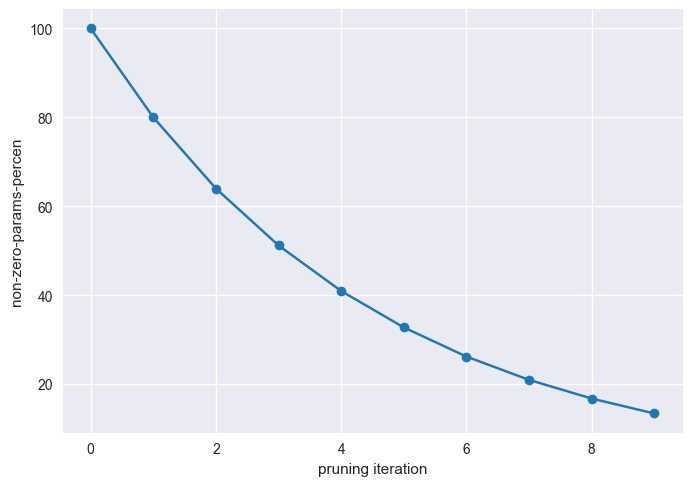

In [15]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.plot(nonzero_param_percent,'-o')
ax.set_xlabel('pruning iteration')
ax.set_ylabel('non-zero-params-percen')

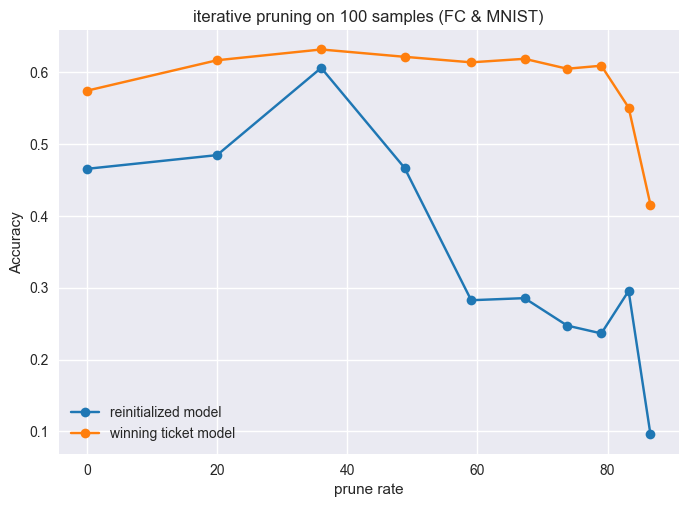

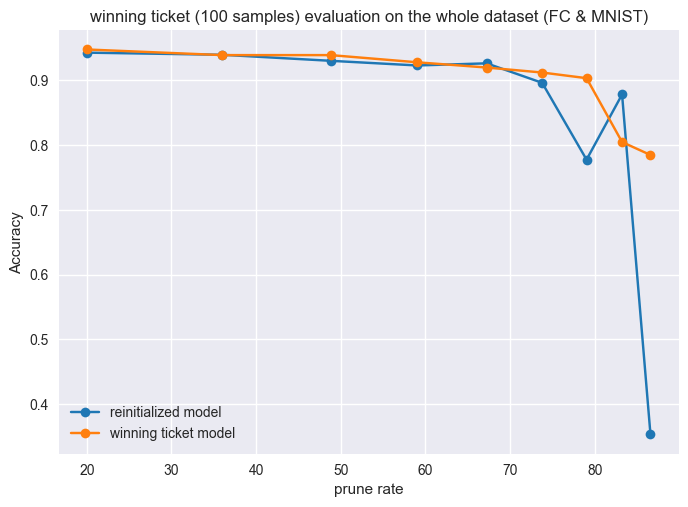

In [25]:
result_reinit_true = torch.load('exp_result/fc_mnist_2_10_0.001_100_reinit-True.pth')
result_reinit_false = torch.load('exp_result/fc_mnist_2_10_0.001_100_reinit-False.pth')

finalValLoss_reinit_true = []
finalAccu_reinit_true = []
finalValLoss_reinit_false = []
finalAccu_reinit_false = []

for dic_key in result_reinit_true:
  finalValLoss_reinit_true.append(result_reinit_true[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true.append(result_reinit_true[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false.append(result_reinit_false[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false.append(result_reinit_false[dic_key]['accu_per_epoch'][-1])

result_reinit_true_evaluate = torch.load('exp_result/fc_mnist_2_10_0.001_100_reinit-True_evaluate.pth')
result_reinit_false_evaluate = torch.load('exp_result/fc_mnist_2_10_0.001_100_reinit-False_evaluate.pth')

finalValLoss_reinit_true_evaluate = []
finalAccu_reinit_true_evaluate = []
finalValLoss_reinit_false_evaluate = []
finalAccu_reinit_false_evaluate = []

for dic_key in result_reinit_true_evaluate:
  finalValLoss_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['accu_per_epoch'][-1])

fig,ax = plt.subplots()
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_true,'-o',label='reinitialized model')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_false,'-o',label='winning ticket model')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.set_title('iterative pruning on 100 samples (FC & MNIST)')
ax.legend()

fig,ax = plt.subplots()
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_true_evaluate,'-o',label='reinitialized model')
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_false_evaluate,'-o',label='winning ticket model')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.set_title('winning ticket (100 samples) evaluation on the whole dataset (FC & MNIST)')
ax.legend()


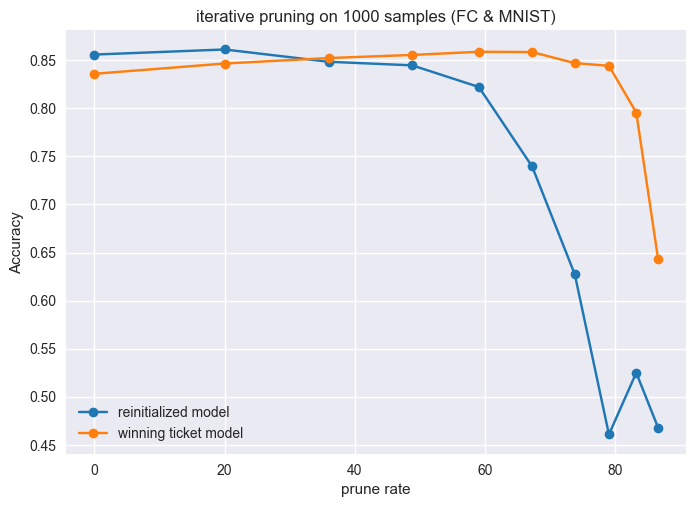

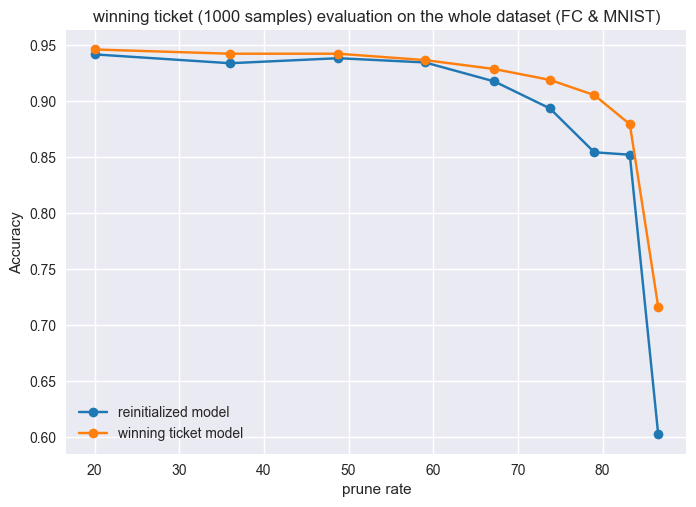

In [26]:
result_reinit_true = torch.load('exp_result/fc_mnist_2_10_0.001_1000_reinit-True.pth')
result_reinit_false = torch.load('exp_result/fc_mnist_2_10_0.001_1000_reinit-False.pth')

finalValLoss_reinit_true = []
finalAccu_reinit_true = []
finalValLoss_reinit_false = []
finalAccu_reinit_false = []

for dic_key in result_reinit_true:
  finalValLoss_reinit_true.append(result_reinit_true[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true.append(result_reinit_true[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false.append(result_reinit_false[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false.append(result_reinit_false[dic_key]['accu_per_epoch'][-1])

result_reinit_true_evaluate = torch.load('exp_result/fc_mnist_2_10_0.001_1000_reinit-True_evaluate.pth')
result_reinit_false_evaluate = torch.load('exp_result/fc_mnist_2_10_0.001_1000_reinit-False_evaluate.pth')

finalValLoss_reinit_true_evaluate = []
finalAccu_reinit_true_evaluate = []
finalValLoss_reinit_false_evaluate = []
finalAccu_reinit_false_evaluate = []

for dic_key in result_reinit_true_evaluate:
  finalValLoss_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['accu_per_epoch'][-1])

fig,ax = plt.subplots()
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_true,'-o',label='reinitialized model')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_false,'-o',label='winning ticket model')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.set_title('iterative pruning on 1000 samples (FC & MNIST)')
ax.legend()

fig,ax = plt.subplots()
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_true_evaluate,'-o',label='reinitialized model')
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_false_evaluate,'-o',label='winning ticket model')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.set_title('winning ticket (1000 samples) evaluation on the whole dataset (FC & MNIST)')
ax.legend()

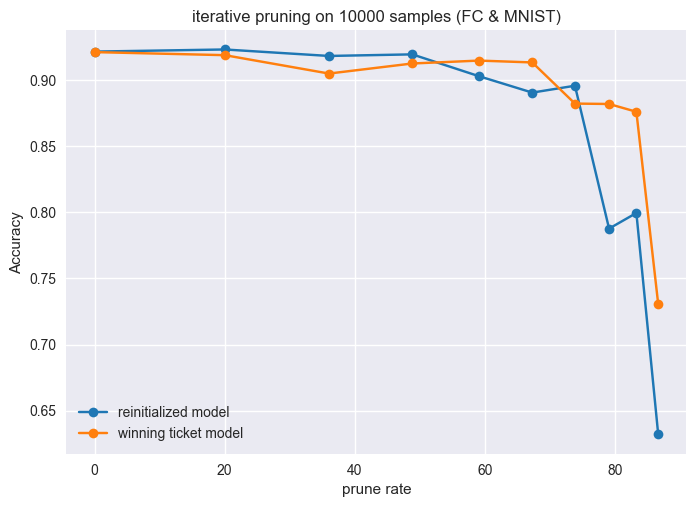

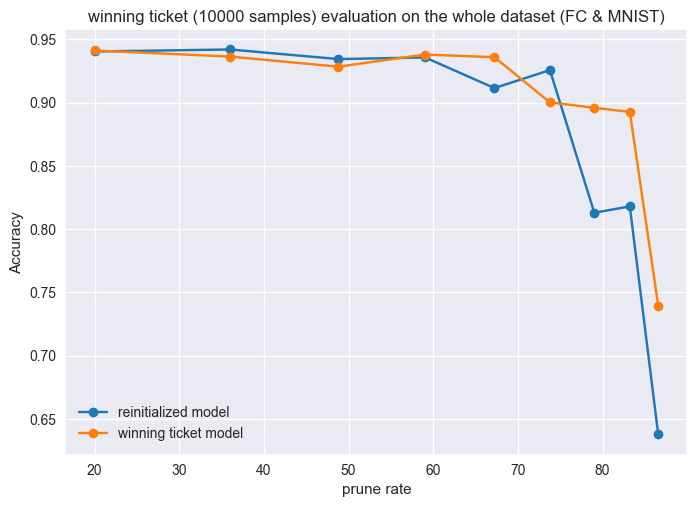

In [27]:
result_reinit_true = torch.load('exp_result/fc_mnist_2_10_0.001_10000_reinit-True.pth')
result_reinit_false = torch.load('exp_result/fc_mnist_2_10_0.001_10000_reinit-False.pth')

finalValLoss_reinit_true = []
finalAccu_reinit_true = []
finalValLoss_reinit_false = []
finalAccu_reinit_false = []

for dic_key in result_reinit_true:
  finalValLoss_reinit_true.append(result_reinit_true[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true.append(result_reinit_true[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false.append(result_reinit_false[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false.append(result_reinit_false[dic_key]['accu_per_epoch'][-1])

result_reinit_true_evaluate = torch.load('exp_result/fc_mnist_2_10_0.001_10000_reinit-True_evaluate.pth')
result_reinit_false_evaluate = torch.load('exp_result/fc_mnist_2_10_0.001_10000_reinit-False_evaluate.pth')

finalValLoss_reinit_true_evaluate = []
finalAccu_reinit_true_evaluate = []
finalValLoss_reinit_false_evaluate = []
finalAccu_reinit_false_evaluate = []

for dic_key in result_reinit_true_evaluate:
  finalValLoss_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['accu_per_epoch'][-1])

fig,ax = plt.subplots()
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_true,'-o',label='reinitialized model')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_false,'-o',label='winning ticket model')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.set_title('iterative pruning on 10000 samples (FC & MNIST)')
ax.legend()

fig,ax = plt.subplots()
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_true_evaluate,'-o',label='reinitialized model')
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_false_evaluate,'-o',label='winning ticket model')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.set_title('winning ticket (10000 samples) evaluation on the whole dataset (FC & MNIST)')
ax.legend()

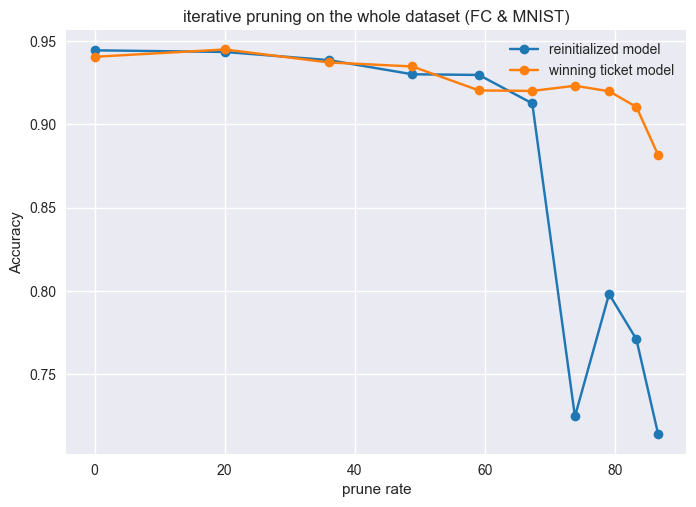

In [28]:
result_reinit_true = torch.load('exp_result/fc_mnist_2_10_0.001_60000_reinit-True.pth')
result_reinit_false = torch.load('exp_result/fc_mnist_2_10_0.001_60000_reinit-False.pth')

finalValLoss_reinit_true = []
finalAccu_reinit_true = []
finalValLoss_reinit_false = []
finalAccu_reinit_false = []

for dic_key in result_reinit_true:
  finalValLoss_reinit_true.append(result_reinit_true[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true.append(result_reinit_true[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false.append(result_reinit_false[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false.append(result_reinit_false[dic_key]['accu_per_epoch'][-1])

# result_reinit_true_evaluate = torch.load('exp_result/fc_mnist_2_10_0.001_60000_reinit-True_evaluate.pth')
# result_reinit_false_evaluate = torch.load('exp_result/fc_mnist_2_10_0.001_60000_reinit-False_evaluate.pth')

finalValLoss_reinit_true_evaluate = []
finalAccu_reinit_true_evaluate = []
finalValLoss_reinit_false_evaluate = []
finalAccu_reinit_false_evaluate = []

for dic_key in result_reinit_true_evaluate:
  finalValLoss_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['accu_per_epoch'][-1])

fig,ax = plt.subplots()
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_true,'-o',label='reinitialized model')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_false,'-o',label='winning ticket model')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.set_title('iterative pruning on the whole dataset (FC & MNIST)')
ax.legend()

# fig,ax = plt.subplots()
# ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_true_evaluate,'-o',label='reinit-true')
# ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_false_evaluate,'-o',label='reinit-false')
# ax.set_xlabel('prune rate')
# ax.set_ylabel('Accuracy')
# ax.legend()

In [35]:
result_reinit_true_evaluate_100 = torch.load('exp_result/fc_mnist_2_10_0.001_100_reinit-True_evaluate.pth')
result_reinit_false_evaluate_100 = torch.load('exp_result/fc_mnist_2_10_0.001_100_reinit-False_evaluate.pth')

result_reinit_true_evaluate_1000 = torch.load('exp_result/fc_mnist_2_10_0.001_1000_reinit-True_evaluate.pth')
result_reinit_false_evaluate_1000 = torch.load('exp_result/fc_mnist_2_10_0.001_1000_reinit-False_evaluate.pth')

result_reinit_true_evaluate_10000 = torch.load('exp_result/fc_mnist_2_10_0.001_10000_reinit-True_evaluate.pth')
result_reinit_false_evaluate_10000 = torch.load('exp_result/fc_mnist_2_10_0.001_10000_reinit-False_evaluate.pth')

result_reinit_true_evaluate_60000 = torch.load('exp_result/fc_mnist_2_10_0.001_60000_reinit-True.pth')
result_reinit_false_evaluate_60000 = torch.load('exp_result/fc_mnist_2_10_0.001_60000_reinit-False.pth')


finalValLoss_reinit_true_evaluate_100 = []
finalAccu_reinit_true_evaluate_100 = []
finalValLoss_reinit_false_evaluate_100 = []
finalAccu_reinit_false_evaluate_100 = []
for dic_key in result_reinit_true_evaluate_100:
  finalValLoss_reinit_true_evaluate_100.append(result_reinit_true_evaluate_100[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true_evaluate_100.append(result_reinit_true_evaluate_100[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false_evaluate_100.append(result_reinit_false_evaluate_100[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false_evaluate_100.append(result_reinit_false_evaluate_100[dic_key]['accu_per_epoch'][-1])

finalValLoss_reinit_true_evaluate_1000 = []
finalAccu_reinit_true_evaluate_1000 = []
finalValLoss_reinit_false_evaluate_1000 = []
finalAccu_reinit_false_evaluate_1000 = []
for dic_key in result_reinit_true_evaluate_1000:
  finalValLoss_reinit_true_evaluate_1000.append(result_reinit_true_evaluate_1000[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true_evaluate_1000.append(result_reinit_true_evaluate_1000[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false_evaluate_1000.append(result_reinit_false_evaluate_1000[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false_evaluate_1000.append(result_reinit_false_evaluate_1000[dic_key]['accu_per_epoch'][-1])

finalValLoss_reinit_true_evaluate_10000 = []
finalAccu_reinit_true_evaluate_10000 = []
finalValLoss_reinit_false_evaluate_10000 = []
finalAccu_reinit_false_evaluate_10000 = []
for dic_key in result_reinit_true_evaluate_10000:
  finalValLoss_reinit_true_evaluate_10000.append(result_reinit_true_evaluate_10000[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true_evaluate_10000.append(result_reinit_true_evaluate_10000[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false_evaluate_10000.append(result_reinit_false_evaluate_10000[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false_evaluate_10000.append(result_reinit_false_evaluate_10000[dic_key]['accu_per_epoch'][-1])

finalValLoss_reinit_true_evaluate_60000 = []
finalAccu_reinit_true_evaluate_60000 = []
finalValLoss_reinit_false_evaluate_60000 = []
finalAccu_reinit_false_evaluate_60000 = []
for dic_key in result_reinit_true_evaluate_60000:
  finalValLoss_reinit_true_evaluate_60000.append(result_reinit_true_evaluate_60000[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true_evaluate_60000.append(result_reinit_true_evaluate_60000[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false_evaluate_60000.append(result_reinit_false_evaluate_60000[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false_evaluate_60000.append(result_reinit_false_evaluate_60000[dic_key]['accu_per_epoch'][-1])

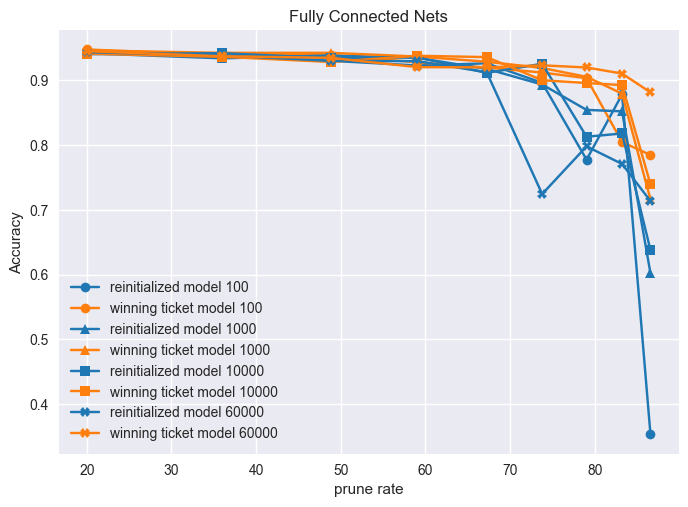

In [36]:
fig,ax = plt.subplots()
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_true_evaluate_100,'-o',label='reinitialized model 100',color='C0')
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_false_evaluate_100,'-o',label='winning ticket model 100',color='C1')

ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_true_evaluate_1000,'-^',label='reinitialized model 1000',color='C0')
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_false_evaluate_1000,'-^',label='winning ticket model 1000',color='C1')

ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_true_evaluate_10000,'-s',label='reinitialized model 10000',color='C0')
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_false_evaluate_10000,'-s',label='winning ticket model 10000',color='C1')

ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_true_evaluate_60000[1:],'-X',label='reinitialized model 60000',color='C0')
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_false_evaluate_60000[1:],'-X',label='winning ticket model 60000',color='C1')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.set_title('Fully Connected Nets')
ax.legend()

In [45]:
print('validation loss improvement:',(- finalValLoss_reinit_false_evaluate_100[-1] + finalValLoss_reinit_true_evaluate_100[-1])/finalValLoss_reinit_true_evaluate_100[-1])
print('validation loss improvement:',(- finalValLoss_reinit_false_evaluate_1000[-1] + finalValLoss_reinit_true_evaluate_1000[-1])/finalValLoss_reinit_true_evaluate_1000[-1])
print('validation loss improvement:',(- finalValLoss_reinit_false_evaluate_10000[-1] + finalValLoss_reinit_true_evaluate_10000[-1])/finalValLoss_reinit_true_evaluate_10000[-1])
print('validation loss improvement:',(- finalValLoss_reinit_false_evaluate_60000[-1] + finalValLoss_reinit_true_evaluate_60000[-1])/finalValLoss_reinit_true_evaluate_60000[-1])

validation loss improvement: 0.6448321350581963
validation loss improvement: 0.3053181961810113
validation loss improvement: 0.31126481219522506
validation loss improvement: 0.515688449628811


In [43]:
print('accuracy improvement:',finalAccu_reinit_false_evaluate_100[-1] - finalAccu_reinit_true_evaluate_100[-1])
print('accuracy improvement:',finalAccu_reinit_false_evaluate_1000[-1] - finalAccu_reinit_true_evaluate_1000[-1])
print('accuracy improvement:',finalAccu_reinit_false_evaluate_10000[-1] - finalAccu_reinit_true_evaluate_10000[-1])
print('accuracy improvement:',finalAccu_reinit_false_evaluate_60000[-1] - finalAccu_reinit_true_evaluate_60000[-1])

accuracy improvement: 0.43150000000000005
accuracy improvement: 0.11409999999999998
accuracy improvement: 0.1018
accuracy improvement: 0.16779999999999995


In [201]:
# fig,ax = plt.subplots()
# sampleSize = [100,1000,10000,60000]
# prune_iter = -4
# res_reinit = [finalAccu_reinit_true_evaluate_100[prune_iter],finalAccu_reinit_true_evaluate_1000[prune_iter],finalAccu_reinit_true_evaluate_10000[prune_iter],finalAccu_reinit_true_evaluate_60000[prune_iter]]
# res_tickets = [finalAccu_reinit_false_evaluate_100[prune_iter],finalAccu_reinit_false_evaluate_1000[prune_iter],finalAccu_reinit_false_evaluate_10000[prune_iter],finalAccu_reinit_false_evaluate_60000[prune_iter]]
# ax.plot(sampleSize,res_reinit,'-o')
# ax.plot(sampleSize,res_tickets,'-o')
# ax.set_xlabel('sample size')
# ax.set_ylabel('Accuracy')
# ax.semilogx()
# ax.set_title(f'#params percent: {nonzero_param_percent[prune_iter]}%')
# ax.legend()

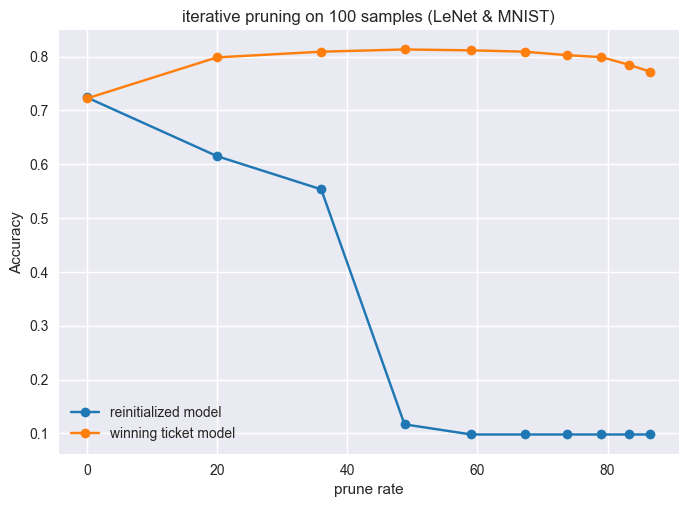

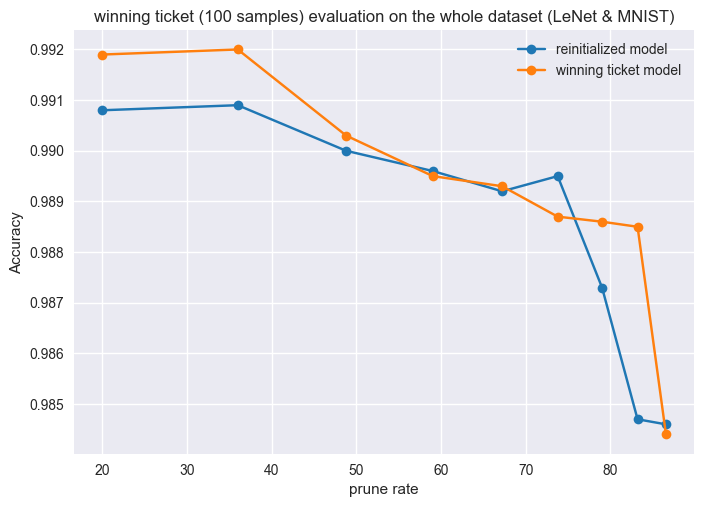

In [29]:
result_reinit_true = torch.load('exp_result/lenet_mnist_2_10_0.001_100_reinit-True.pth')
result_reinit_false = torch.load('exp_result/lenet_mnist_2_10_0.001_100_reinit-False.pth')

finalValLoss_reinit_true = []
finalAccu_reinit_true = []
finalValLoss_reinit_false = []
finalAccu_reinit_false = []

for dic_key in result_reinit_true:
  finalValLoss_reinit_true.append(result_reinit_true[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true.append(result_reinit_true[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false.append(result_reinit_false[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false.append(result_reinit_false[dic_key]['accu_per_epoch'][-1])

result_reinit_true_evaluate = torch.load('exp_result/lenet_mnist_2_10_0.001_100_reinit-True_evaluate.pth')
result_reinit_false_evaluate = torch.load('exp_result/lenet_mnist_2_10_0.001_100_reinit-False_evaluate.pth')

finalValLoss_reinit_true_evaluate = []
finalAccu_reinit_true_evaluate = []
finalValLoss_reinit_false_evaluate = []
finalAccu_reinit_false_evaluate = []

for dic_key in result_reinit_true_evaluate:
  finalValLoss_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['accu_per_epoch'][-1])

fig,ax = plt.subplots()
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_true,'-o',label='reinitialized model')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_false,'-o',label='winning ticket model')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.set_title('iterative pruning on 100 samples (LeNet & MNIST)')
ax.legend()

fig,ax = plt.subplots()
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_true_evaluate,'-o',label='reinitialized model')
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_false_evaluate,'-o',label='winning ticket model')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.set_title('winning ticket (100 samples) evaluation on the whole dataset (LeNet & MNIST)')
ax.legend()


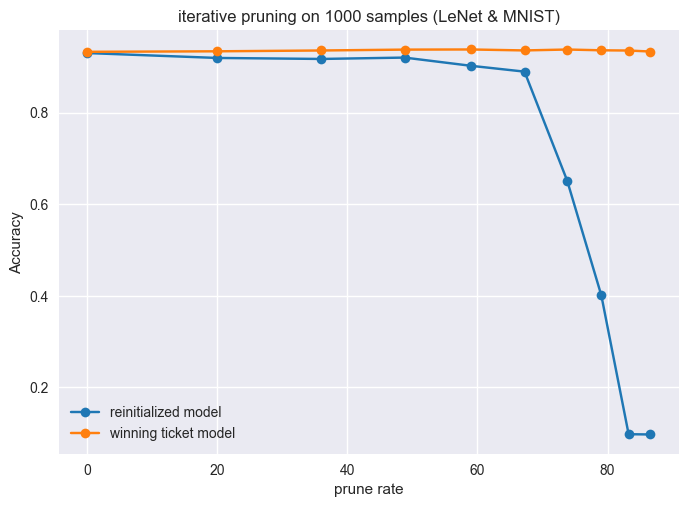

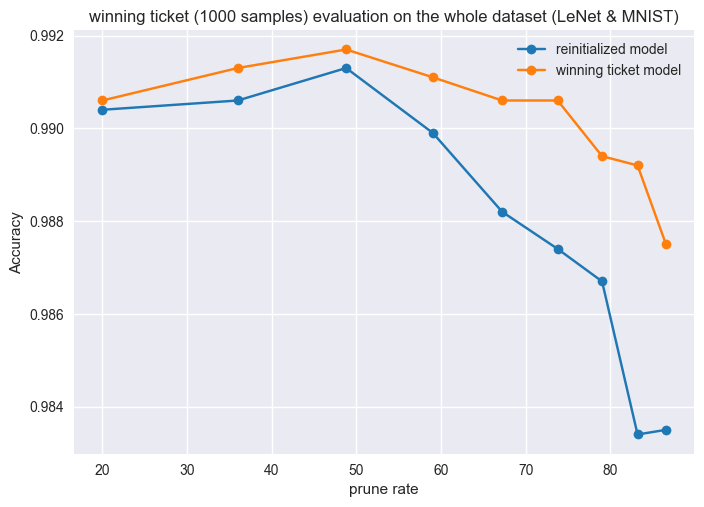

In [30]:
result_reinit_true = torch.load('exp_result/lenet_mnist_2_10_0.001_1000_reinit-True.pth')
result_reinit_false = torch.load('exp_result/lenet_mnist_2_10_0.001_1000_reinit-False.pth')

finalValLoss_reinit_true = []
finalAccu_reinit_true = []
finalValLoss_reinit_false = []
finalAccu_reinit_false = []

for dic_key in result_reinit_true:
  finalValLoss_reinit_true.append(result_reinit_true[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true.append(result_reinit_true[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false.append(result_reinit_false[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false.append(result_reinit_false[dic_key]['accu_per_epoch'][-1])

result_reinit_true_evaluate = torch.load('exp_result/lenet_mnist_2_10_0.001_1000_reinit-True_evaluate.pth')
result_reinit_false_evaluate = torch.load('exp_result/lenet_mnist_2_10_0.001_1000_reinit-False_evaluate.pth')

finalValLoss_reinit_true_evaluate = []
finalAccu_reinit_true_evaluate = []
finalValLoss_reinit_false_evaluate = []
finalAccu_reinit_false_evaluate = []

for dic_key in result_reinit_true_evaluate:
  finalValLoss_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['accu_per_epoch'][-1])

fig,ax = plt.subplots()
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_true,'-o',label='reinitialized model')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_false,'-o',label='winning ticket model')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.set_title('iterative pruning on 1000 samples (LeNet & MNIST)')
ax.legend()

fig,ax = plt.subplots()
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_true_evaluate,'-o',label='reinitialized model')
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_false_evaluate,'-o',label='winning ticket model')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.set_title('winning ticket (1000 samples) evaluation on the whole dataset (LeNet & MNIST)')
ax.legend()


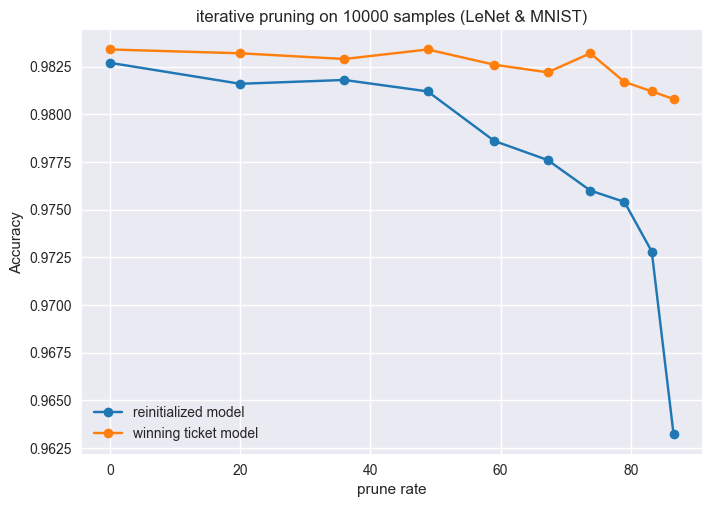

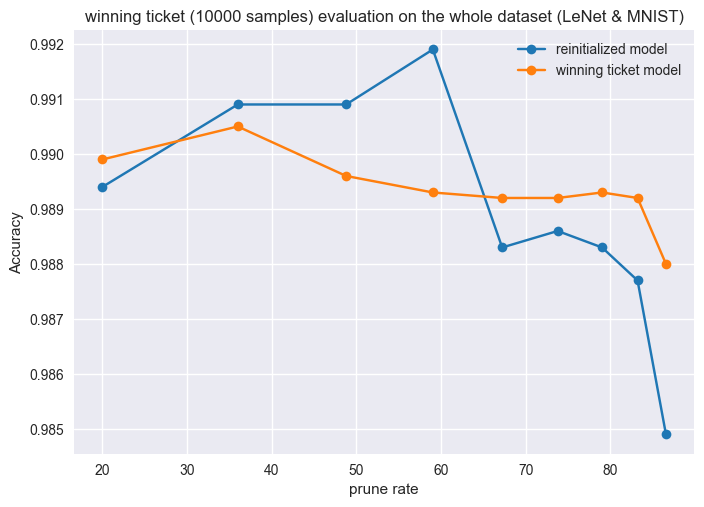

In [31]:
result_reinit_true = torch.load('exp_result/lenet_mnist_2_10_0.001_10000_reinit-True.pth')
result_reinit_false = torch.load('exp_result/lenet_mnist_2_10_0.001_10000_reinit-False.pth')

finalValLoss_reinit_true = []
finalAccu_reinit_true = []
finalValLoss_reinit_false = []
finalAccu_reinit_false = []

for dic_key in result_reinit_true:
  finalValLoss_reinit_true.append(result_reinit_true[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true.append(result_reinit_true[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false.append(result_reinit_false[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false.append(result_reinit_false[dic_key]['accu_per_epoch'][-1])

result_reinit_true_evaluate = torch.load('exp_result/lenet_mnist_2_10_0.001_10000_reinit-True_evaluate.pth')
result_reinit_false_evaluate = torch.load('exp_result/lenet_mnist_2_10_0.001_10000_reinit-False_evaluate.pth')

finalValLoss_reinit_true_evaluate = []
finalAccu_reinit_true_evaluate = []
finalValLoss_reinit_false_evaluate = []
finalAccu_reinit_false_evaluate = []

for dic_key in result_reinit_true_evaluate:
  finalValLoss_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['accu_per_epoch'][-1])

fig,ax = plt.subplots()
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_true,'-o',label='reinitialized model')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_false,'-o',label='winning ticket model')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.set_title('iterative pruning on 10000 samples (LeNet & MNIST)')
ax.legend()

fig,ax = plt.subplots()
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_true_evaluate,'-o',label='reinitialized model')
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_false_evaluate,'-o',label='winning ticket model')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.set_title('winning ticket (10000 samples) evaluation on the whole dataset (LeNet & MNIST)')
ax.legend()


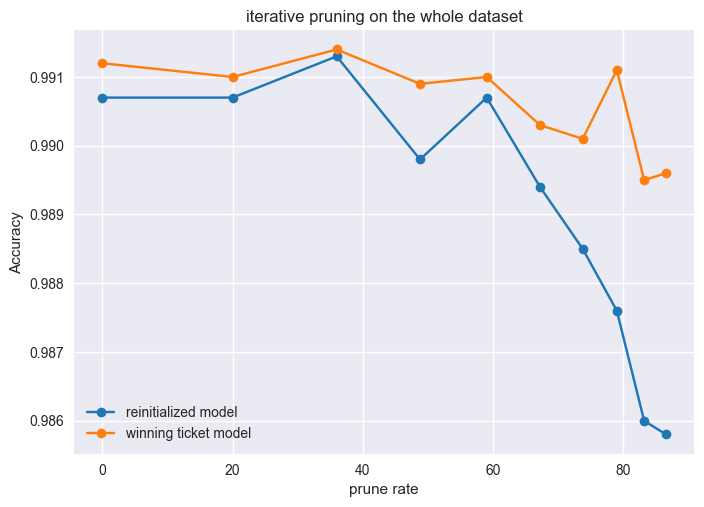

In [32]:
result_reinit_true = torch.load('exp_result/lenet_mnist_2_10_0.001_60000_reinit-True.pth')
result_reinit_false = torch.load('exp_result/lenet_mnist_2_10_0.001_60000_reinit-False.pth')

finalValLoss_reinit_true = []
finalAccu_reinit_true = []
finalValLoss_reinit_false = []
finalAccu_reinit_false = []

for dic_key in result_reinit_true:
  finalValLoss_reinit_true.append(result_reinit_true[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true.append(result_reinit_true[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false.append(result_reinit_false[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false.append(result_reinit_false[dic_key]['accu_per_epoch'][-1])

# result_reinit_true_evaluate = torch.load('exp_result/lenet_mnist_2_10_0.001_10000_reinit-True_evaluate.pth')
# result_reinit_false_evaluate = torch.load('exp_result/lenet_mnist_2_10_0.001_10000_reinit-False_evaluate.pth')

finalValLoss_reinit_true_evaluate = []
finalAccu_reinit_true_evaluate = []
finalValLoss_reinit_false_evaluate = []
finalAccu_reinit_false_evaluate = []

for dic_key in result_reinit_true_evaluate:
  finalValLoss_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['accu_per_epoch'][-1])

fig,ax = plt.subplots()
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_true,'-o',label='reinitialized model')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_false,'-o',label='winning ticket model')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.set_title('iterative pruning on the whole dataset')
ax.legend()

# fig,ax = plt.subplots()
# ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_true_evaluate,'-o',label='reinitialized model')
# ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_false_evaluate,'-o',label='winning ticket model')
# ax.set_xlabel('prune rate')
# ax.set_ylabel('Accuracy')
# ax.legend()


In [48]:
result_reinit_true_evaluate_100 = torch.load('exp_result/lenet_mnist_2_10_0.001_100_reinit-True_evaluate.pth')
result_reinit_false_evaluate_100 = torch.load('exp_result/lenet_mnist_2_10_0.001_100_reinit-False_evaluate.pth')

result_reinit_true_evaluate_1000 = torch.load('exp_result/lenet_mnist_2_10_0.001_1000_reinit-True_evaluate.pth')
result_reinit_false_evaluate_1000 = torch.load('exp_result/lenet_mnist_2_10_0.001_1000_reinit-False_evaluate.pth')

result_reinit_true_evaluate_10000 = torch.load('exp_result/lenet_mnist_2_10_0.001_10000_reinit-True_evaluate.pth')
result_reinit_false_evaluate_10000 = torch.load('exp_result/lenet_mnist_2_10_0.001_10000_reinit-False_evaluate.pth')

result_reinit_true_evaluate_60000 = torch.load('exp_result/lenet_mnist_2_10_0.001_60000_reinit-True.pth')
result_reinit_false_evaluate_60000 = torch.load('exp_result/lenet_mnist_2_10_0.001_60000_reinit-False.pth')


finalValLoss_reinit_true_evaluate_100 = []
finalAccu_reinit_true_evaluate_100 = []
finalValLoss_reinit_false_evaluate_100 = []
finalAccu_reinit_false_evaluate_100 = []
for dic_key in result_reinit_true_evaluate_100:
  finalValLoss_reinit_true_evaluate_100.append(result_reinit_true_evaluate_100[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true_evaluate_100.append(result_reinit_true_evaluate_100[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false_evaluate_100.append(result_reinit_false_evaluate_100[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false_evaluate_100.append(result_reinit_false_evaluate_100[dic_key]['accu_per_epoch'][-1])

finalValLoss_reinit_true_evaluate_1000 = []
finalAccu_reinit_true_evaluate_1000 = []
finalValLoss_reinit_false_evaluate_1000 = []
finalAccu_reinit_false_evaluate_1000 = []
for dic_key in result_reinit_true_evaluate_1000:
  finalValLoss_reinit_true_evaluate_1000.append(result_reinit_true_evaluate_1000[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true_evaluate_1000.append(result_reinit_true_evaluate_1000[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false_evaluate_1000.append(result_reinit_false_evaluate_1000[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false_evaluate_1000.append(result_reinit_false_evaluate_1000[dic_key]['accu_per_epoch'][-1])

finalValLoss_reinit_true_evaluate_10000 = []
finalAccu_reinit_true_evaluate_10000 = []
finalValLoss_reinit_false_evaluate_10000 = []
finalAccu_reinit_false_evaluate_10000 = []
for dic_key in result_reinit_true_evaluate_10000:
  finalValLoss_reinit_true_evaluate_10000.append(result_reinit_true_evaluate_10000[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true_evaluate_10000.append(result_reinit_true_evaluate_10000[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false_evaluate_10000.append(result_reinit_false_evaluate_10000[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false_evaluate_10000.append(result_reinit_false_evaluate_10000[dic_key]['accu_per_epoch'][-1])

finalValLoss_reinit_true_evaluate_60000 = []
finalAccu_reinit_true_evaluate_60000 = []
finalValLoss_reinit_false_evaluate_60000 = []
finalAccu_reinit_false_evaluate_60000 = []
for dic_key in result_reinit_true_evaluate_60000:
  finalValLoss_reinit_true_evaluate_60000.append(result_reinit_true_evaluate_60000[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true_evaluate_60000.append(result_reinit_true_evaluate_60000[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false_evaluate_60000.append(result_reinit_false_evaluate_60000[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false_evaluate_60000.append(result_reinit_false_evaluate_60000[dic_key]['accu_per_epoch'][-1])

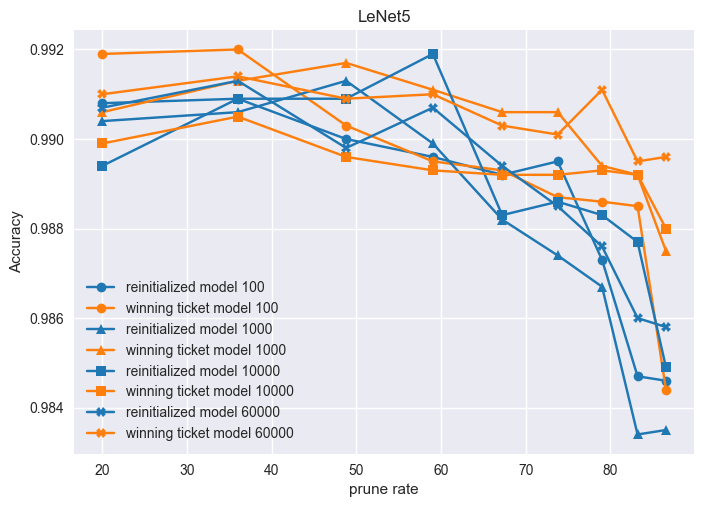

In [49]:
fig,ax = plt.subplots()
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_true_evaluate_100,'-o',label='reinitialized model 100',color='C0')
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_false_evaluate_100,'-o',label='winning ticket model 100',color='C1')

ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_true_evaluate_1000,'-^',label='reinitialized model 1000',color='C0')
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_false_evaluate_1000,'-^',label='winning ticket model 1000',color='C1')

ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_true_evaluate_10000,'-s',label='reinitialized model 10000',color='C0')
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_false_evaluate_10000,'-s',label='winning ticket model 10000',color='C1')

ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_true_evaluate_60000[1:],'-X',label='reinitialized model 60000',color='C0')
ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_false_evaluate_60000[1:],'-X',label='winning ticket model 60000',color='C1')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.set_title('LeNet5')
ax.legend()

In [50]:
print('validation loss improvement:',(- finalValLoss_reinit_false_evaluate_100[-1] + finalValLoss_reinit_true_evaluate_100[-1])/finalValLoss_reinit_true_evaluate_100[-1])
print('validation loss improvement:',(- finalValLoss_reinit_false_evaluate_1000[-1] + finalValLoss_reinit_true_evaluate_1000[-1])/finalValLoss_reinit_true_evaluate_1000[-1])
print('validation loss improvement:',(- finalValLoss_reinit_false_evaluate_10000[-1] + finalValLoss_reinit_true_evaluate_10000[-1])/finalValLoss_reinit_true_evaluate_10000[-1])
print('validation loss improvement:',(- finalValLoss_reinit_false_evaluate_60000[-1] + finalValLoss_reinit_true_evaluate_60000[-1])/finalValLoss_reinit_true_evaluate_60000[-1])

validation loss improvement: 0.11090827500809608
validation loss improvement: 0.19984747282100146
validation loss improvement: 0.2838738013819977
validation loss improvement: 0.14564973569332892


In [49]:
print('accuracy improvement:',finalAccu_reinit_false_evaluate_100[-1] - finalAccu_reinit_true_evaluate_100[-1])
print('accuracy improvement:',finalAccu_reinit_false_evaluate_1000[-1] - finalAccu_reinit_true_evaluate_1000[-1])
print('accuracy improvement:',finalAccu_reinit_false_evaluate_10000[-1] - finalAccu_reinit_true_evaluate_10000[-1])
print('accuracy improvement:',finalAccu_reinit_false_evaluate_60000[-1] - finalAccu_reinit_true_evaluate_60000[-1])

accuracy improvement: -0.00019999999999997797
accuracy improvement: 0.0040000000000000036
accuracy improvement: 0.0030999999999999917
accuracy improvement: 0.0038000000000000256


# Cross-model-size

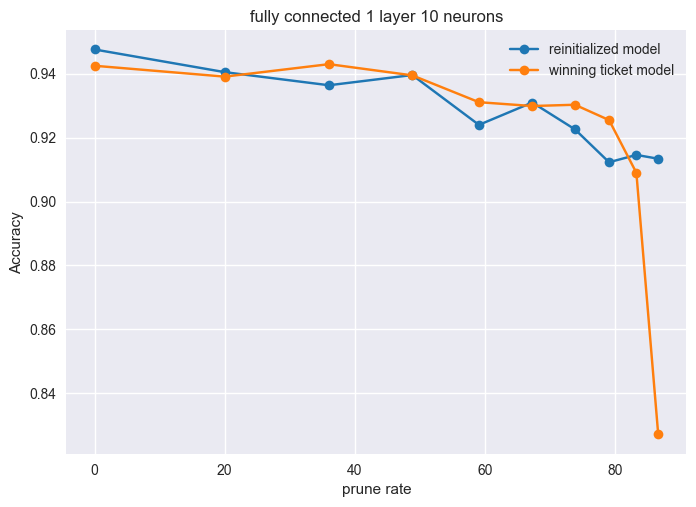

In [51]:
result_reinit_true = torch.load('exp_result/fc_mnist_1_10_0.001_60000_reinit-True.pth')
result_reinit_false = torch.load('exp_result/fc_mnist_1_10_0.001_60000_reinit-False.pth')

finalValLoss_reinit_true = []
finalAccu_reinit_true = []
finalValLoss_reinit_false = []
finalAccu_reinit_false = []

for dic_key in result_reinit_true:
  finalValLoss_reinit_true.append(result_reinit_true[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true.append(result_reinit_true[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false.append(result_reinit_false[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false.append(result_reinit_false[dic_key]['accu_per_epoch'][-1])

# result_reinit_true_evaluate = torch.load('exp_result/fc_mnist_2_100_0.001_60000_reinit-True_evaluate.pth')
# result_reinit_false_evaluate = torch.load('exp_result/fc_mnist_2_100_0.001_60000_reinit-False_evaluate.pth')

finalValLoss_reinit_true_evaluate = []
finalAccu_reinit_true_evaluate = []
finalValLoss_reinit_false_evaluate = []
finalAccu_reinit_false_evaluate = []

for dic_key in result_reinit_true_evaluate:
  finalValLoss_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['accu_per_epoch'][-1])

fig,ax = plt.subplots()
ax.set_title('fully connected 1 layer 10 neurons')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_true,'-o',label='reinitialized model')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_false,'-o',label='winning ticket model')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.legend()

# fig,ax = plt.subplots()
# ax.set_title('retrain pruned models')
# ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_true_evaluate,'-o',label='reinit-model-evaluate')
# ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_false_evaluate,'-o',label='winning-ticket-model-evalute')
# ax.set_xlabel('prune rate')
# ax.set_ylabel('Accuracy')
# ax.legend()

In [52]:
print('validation loss improvement:',(finalValLoss_reinit_true[-1]-finalValLoss_reinit_false[-1])/finalValLoss_reinit_true[-1])
print('accuracy improvement:',finalAccu_reinit_false[-1] - finalAccu_reinit_true[-1])

validation loss improvement: -0.4709847760578168
accuracy improvement: -0.08630000000000004


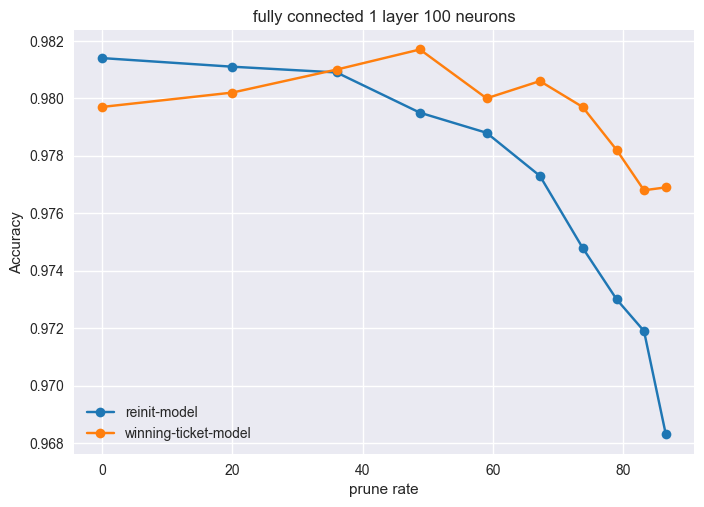

In [53]:
result_reinit_true = torch.load('exp_result/fc_mnist_1_100_0.001_60000_reinit-True.pth')
result_reinit_false = torch.load('exp_result/fc_mnist_1_100_0.001_60000_reinit-False.pth')

finalValLoss_reinit_true = []
finalAccu_reinit_true = []
finalValLoss_reinit_false = []
finalAccu_reinit_false = []

for dic_key in result_reinit_true:
  finalValLoss_reinit_true.append(result_reinit_true[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true.append(result_reinit_true[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false.append(result_reinit_false[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false.append(result_reinit_false[dic_key]['accu_per_epoch'][-1])

# result_reinit_true_evaluate = torch.load('exp_result/fc_mnist_2_100_0.001_60000_reinit-True_evaluate.pth')
# result_reinit_false_evaluate = torch.load('exp_result/fc_mnist_2_100_0.001_60000_reinit-False_evaluate.pth')

finalValLoss_reinit_true_evaluate = []
finalAccu_reinit_true_evaluate = []
finalValLoss_reinit_false_evaluate = []
finalAccu_reinit_false_evaluate = []

for dic_key in result_reinit_true_evaluate:
  finalValLoss_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['accu_per_epoch'][-1])

fig,ax = plt.subplots()
ax.set_title('fully connected 1 layer 100 neurons')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_true,'-o',label='reinit-model')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_false,'-o',label='winning-ticket-model')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.legend()

# fig,ax = plt.subplots()
# ax.set_title('retrain pruned models')
# ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_true_evaluate,'-o',label='reinit-model-evaluate')
# ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_false_evaluate,'-o',label='winning-ticket-model-evalute')
# ax.set_xlabel('prune rate')
# ax.set_ylabel('Accuracy')
# ax.legend()

In [54]:
print('validation loss improvement:',(finalValLoss_reinit_true[-1]-finalValLoss_reinit_false[-1])/finalValLoss_reinit_true[-1])
print('accuracy improvement:',finalAccu_reinit_false[-1] - finalAccu_reinit_true[-1])

validation loss improvement: 0.07095643252714422
accuracy improvement: 0.008599999999999941


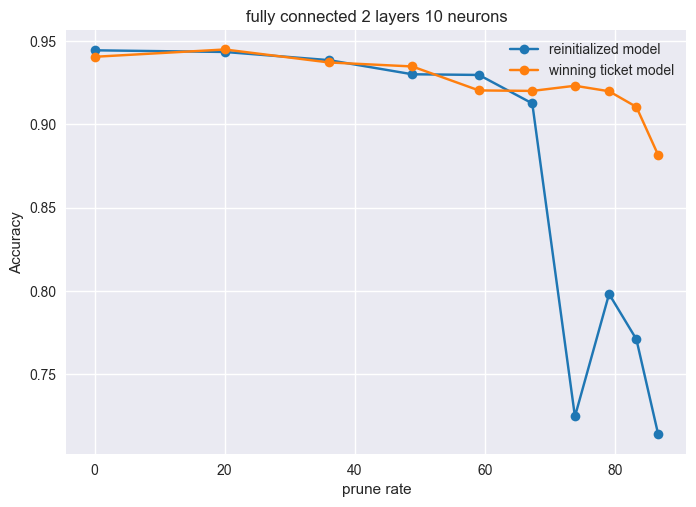

In [55]:
result_reinit_true = torch.load('exp_result/fc_mnist_2_10_0.001_60000_reinit-True.pth')
result_reinit_false = torch.load('exp_result/fc_mnist_2_10_0.001_60000_reinit-False.pth')

finalValLoss_reinit_true = []
finalAccu_reinit_true = []
finalValLoss_reinit_false = []
finalAccu_reinit_false = []

for dic_key in result_reinit_true:
  finalValLoss_reinit_true.append(result_reinit_true[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true.append(result_reinit_true[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false.append(result_reinit_false[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false.append(result_reinit_false[dic_key]['accu_per_epoch'][-1])

# result_reinit_true_evaluate = torch.load('exp_result/fc_mnist_2_100_0.001_60000_reinit-True_evaluate.pth')
# result_reinit_false_evaluate = torch.load('exp_result/fc_mnist_2_100_0.001_60000_reinit-False_evaluate.pth')

finalValLoss_reinit_true_evaluate = []
finalAccu_reinit_true_evaluate = []
finalValLoss_reinit_false_evaluate = []
finalAccu_reinit_false_evaluate = []

for dic_key in result_reinit_true_evaluate:
  finalValLoss_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['accu_per_epoch'][-1])

fig,ax = plt.subplots()
ax.set_title('fully connected 2 layers 10 neurons')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_true,'-o',label='reinitialized model')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_false,'-o',label='winning ticket model')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.legend()

# fig,ax = plt.subplots()
# ax.set_title('retrain pruned models')
# ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_true_evaluate,'-o',label='reinit-model-evaluate')
# ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_false_evaluate,'-o',label='winning-ticket-model-evalute')
# ax.set_xlabel('prune rate')
# ax.set_ylabel('Accuracy')
# ax.legend()

In [56]:
print('validation loss improvement:',(finalValLoss_reinit_true[-1]-finalValLoss_reinit_false[-1])/finalValLoss_reinit_true[-1])
print('accuracy improvement:',finalAccu_reinit_false[-1] - finalAccu_reinit_true[-1])

validation loss improvement: 0.515688449628811
accuracy improvement: 0.16779999999999995


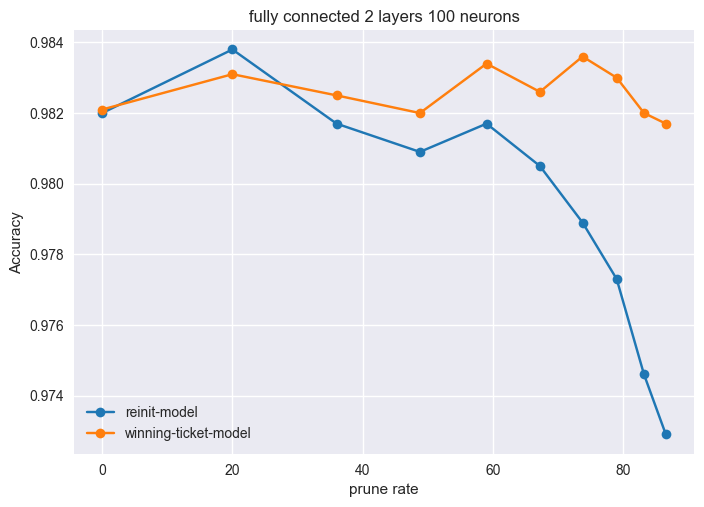

In [57]:
result_reinit_true = torch.load('exp_result/fc_mnist_2_100_0.001_60000_reinit-True.pth')
result_reinit_false = torch.load('exp_result/fc_mnist_2_100_0.001_60000_reinit-False.pth')

finalValLoss_reinit_true = []
finalAccu_reinit_true = []
finalValLoss_reinit_false = []
finalAccu_reinit_false = []

for dic_key in result_reinit_true:
  finalValLoss_reinit_true.append(result_reinit_true[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true.append(result_reinit_true[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false.append(result_reinit_false[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false.append(result_reinit_false[dic_key]['accu_per_epoch'][-1])

# result_reinit_true_evaluate = torch.load('exp_result/fc_mnist_2_100_0.001_60000_reinit-True_evaluate.pth')
# result_reinit_false_evaluate = torch.load('exp_result/fc_mnist_2_100_0.001_60000_reinit-False_evaluate.pth')

finalValLoss_reinit_true_evaluate = []
finalAccu_reinit_true_evaluate = []
finalValLoss_reinit_false_evaluate = []
finalAccu_reinit_false_evaluate = []

for dic_key in result_reinit_true_evaluate:
  finalValLoss_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_true_evaluate.append(result_reinit_true_evaluate[dic_key]['accu_per_epoch'][-1])
  finalValLoss_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['valLoss_per_epoch'][-1])
  finalAccu_reinit_false_evaluate.append(result_reinit_false_evaluate[dic_key]['accu_per_epoch'][-1])

fig,ax = plt.subplots()
ax.set_title('fully connected 2 layers 100 neurons')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_true,'-o',label='reinit-model')
ax.plot(100-np.array(nonzero_param_percent),finalAccu_reinit_false,'-o',label='winning-ticket-model')
ax.set_xlabel('prune rate')
ax.set_ylabel('Accuracy')
ax.legend()

# fig,ax = plt.subplots()
# ax.set_title('retrain pruned models')
# ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_true_evaluate,'-o',label='reinit-model-evaluate')
# ax.plot(100-np.array(nonzero_param_percent)[1:],finalAccu_reinit_false_evaluate,'-o',label='winning-ticket-model-evalute')
# ax.set_xlabel('prune rate')
# ax.set_ylabel('Accuracy')
# ax.legend()

In [58]:
print('validation loss improvement:',(finalValLoss_reinit_true[-1]-finalValLoss_reinit_false[-1])/finalValLoss_reinit_true[-1])
print('accuracy improvement:',finalAccu_reinit_false[-1] - finalAccu_reinit_true[-1])

validation loss improvement: 0.23875347923565712
accuracy improvement: 0.00880000000000003
